## Plots delays, throughputs, packet loss and path for a selected link

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
indices = "network_weather-2017.5.*"

my_query = {}

from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

import time
from sklearn.model_selection import train_test_split

import random

from pandas.tseries.offsets import *

#from graphviz import Source

##  Select your link

In [2]:
# sS='UC'
# srcSiteOWDServer = "192.170.227.160"
# srcSiteThroughputServer = "192.170.227.162"

sS= 'pic'
srcSiteOWDServer = "193.109.172.188"
#srcSiteThroughputServer = "128.142.223.246"

# dS='IU'
# destSiteOWDServer = "149.165.225.223"
# destSiteThroughputServer = "149.165.225.224"

# dS='UIUC'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.96.9"

# dS='ICCN'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.126.132"

dS= 'CERN-PROD'
destSiteOWDServer = "128.142.223.247"
#destSiteThroughputServer = "193.109.172.187"

# dS = 'RO-16-UAIC'
# destSiteOWDServer = "85.122.31.74"

# dS = 'praguelcg2'
# destSiteOWDServer = "147.231.25.192"

# dS = 'MWT2'
# destSiteOWDServer = "149.165.225.223"

# dS = 'UFlorida-HPC'
# destSiteOWDServer = "128.227.221.44"

## Get the data from Elasticsearch, and store the record based on its type

In [3]:
my_query = {
    'query': { 
       'bool':{
            'must':[
                    {'range': {'timestamp': {'gte': '20170501T000000Z', 'lt': '20170531T000000Z'}}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteOWDServer}},
                                #{'term': {'src': srcSiteThroughputServer}},
                                #{'term': {'src': destSiteOWDServer}},
                                #{'term': {'src': destSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteOWDServer}},
                                #{'term': {'dest': destSiteThroughputServer}},
                                #{'term': {'dest': srcSiteOWDServer}},
                                #{'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'_type': 'packet_loss_rate'}},
                                {'term': {'_type': 'latency'}}
                            #{'term': {'_type': ''}},
                            #{'term': {'_type': ''}}
                            ]}
                        }
                    ]
                }
        
        }
    }


scroll = list(scan(client=es, index=indices, query=my_query))

In [4]:
site = {srcSiteOWDServer: sS, destSiteOWDServer:dS}
data = {sS:pd.DataFrame(),dS:pd.DataFrame()}
epoch = datetime.utcfromtimestamp(0)
count = 0
print(epoch)

for res in scroll:
    if count<10: print(res)
    count += 1
#     dt=datetime.strptime(res['_source']['timestamp'], '%Y-%m-%dT%H:%M:%S') # for data before Oct. 15 2016
    dt=datetime.utcfromtimestamp(res['_source']['timestamp']/1000.0)
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    data[s].set_value(ts, 'timestamp', dt)
    column_type = res['_type']
    if column_type == 'latency':
        data[s].set_value( ts, 'delay_median', res['_source']['delay_median'])
        data[s].set_value( ts, 'delay_mean', res['_source']['delay_mean'])
        data[s].set_value( ts, 'delay_sd', res['_source']['delay_sd'])
    elif column_type == 'packet_loss_rate':
        data[s].set_value( ts, 'packet_loss', res['_source']['packet_loss'])
    #if count<2: print(dt)

1970-01-01 00:00:00
{'_index': 'network_weather-2017.5.19', '_id': 'AVweN7RcKw5l0ihiPru_', '_type': 'latency', 'sort': [1793], '_score': None, '_source': {'delay_mean': 56.55739999999998, 'srcProduction': True, 'srcSite': 'pic', 'MA': '193.109.172.188', 'destVO': 'ATLAS', 'dest': '128.142.223.247', 'srcVO': 'ATLAS', 'destSite': 'CERN-PROD', 'destProduction': True, 'timestamp': 1495155236000, 'delay_median': 80.935, 'delay_sd': 34.584030995629554, 'src': '193.109.172.188'}}
{'_index': 'network_weather-2017.5.19', '_id': 'AVweN7RcKw5l0ihiPrvJ', '_type': 'latency', 'sort': [1794], '_score': None, '_source': {'delay_mean': 52.29361666666668, 'srcProduction': True, 'srcSite': 'pic', 'MA': '193.109.172.188', 'destVO': 'ATLAS', 'dest': '128.142.223.247', 'srcVO': 'ATLAS', 'destSite': 'CERN-PROD', 'destProduction': True, 'timestamp': 1495154576000, 'delay_median': 74.295, 'delay_sd': 16.80342799608825, 'src': '193.109.172.188'}}
{'_index': 'network_weather-2017.5.19', '_id': 'AVweN7RcKw5l0ihiP

In [5]:
data[sS].sort_index(inplace=True) 
data[sS].describe()

delay_median    delay_mean      delay_sd   packet_loss
count  79633.000000  79633.000000  79633.000000  79633.000000
mean      16.906252     16.608765      3.925712      0.000124
std        8.093152      6.972179     20.771366      0.006920
min       14.140000      7.576117      0.047664      0.000000
25%       15.140000     15.201050      0.197496      0.000000
50%       15.230000     15.312867      0.436348      0.000000
75%       15.350000     15.500783      1.853790      0.000000
max      101.760000    344.457883   1119.202174      0.565000

In [6]:
print(data[sS])

                       timestamp  delay_median  delay_mean   delay_sd  \
1.493597e+12 2017-05-01 00:00:04        15.240   15.304733   0.601748   
1.493597e+12 2017-05-01 00:00:42        15.210   15.268967   0.394805   
1.493597e+12 2017-05-01 00:01:04        15.190   15.243600   0.555692   
1.493597e+12 2017-05-01 00:01:42        22.765   15.218700   0.361329   
1.493597e+12 2017-05-01 00:02:04        15.180   15.890533   9.572120   
1.493597e+12 2017-05-01 00:02:42        15.170   15.190917   0.106413   
1.493597e+12 2017-05-01 00:03:04        15.180   15.206683   0.162078   
1.493597e+12 2017-05-01 00:03:42        15.200   16.087383  14.567939   
1.493597e+12 2017-05-01 00:04:04        15.180   15.202983   0.086500   
1.493597e+12 2017-05-01 00:04:42        15.200   15.229767   0.203868   
1.493597e+12 2017-05-01 00:05:04        15.200   15.216250   0.146410   
1.493597e+12 2017-05-01 00:05:42        15.190   15.243183   0.718205   
1.493597e+12 2017-05-01 00:06:04        15.200   15

### Extract values

In [7]:
F = data[sS]
Fpl = F[F.packet_loss.notnull()]
Fd = F[F.delay_mean.notnull()]

print(Fpl)

                       timestamp  delay_median  delay_mean   delay_sd  \
1.493597e+12 2017-05-01 00:00:04        15.240   15.304733   0.601748   
1.493597e+12 2017-05-01 00:00:42        15.210   15.268967   0.394805   
1.493597e+12 2017-05-01 00:01:04        15.190   15.243600   0.555692   
1.493597e+12 2017-05-01 00:01:42        22.765   15.218700   0.361329   
1.493597e+12 2017-05-01 00:02:04        15.180   15.890533   9.572120   
1.493597e+12 2017-05-01 00:02:42        15.170   15.190917   0.106413   
1.493597e+12 2017-05-01 00:03:04        15.180   15.206683   0.162078   
1.493597e+12 2017-05-01 00:03:42        15.200   16.087383  14.567939   
1.493597e+12 2017-05-01 00:04:04        15.180   15.202983   0.086500   
1.493597e+12 2017-05-01 00:04:42        15.200   15.229767   0.203868   
1.493597e+12 2017-05-01 00:05:04        15.200   15.216250   0.146410   
1.493597e+12 2017-05-01 00:05:42        15.190   15.243183   0.718205   
1.493597e+12 2017-05-01 00:06:04        15.200   15

In [8]:
print(Fd)

                       timestamp  delay_median  delay_mean   delay_sd  \
1.493597e+12 2017-05-01 00:00:04        15.240   15.304733   0.601748   
1.493597e+12 2017-05-01 00:00:42        15.210   15.268967   0.394805   
1.493597e+12 2017-05-01 00:01:04        15.190   15.243600   0.555692   
1.493597e+12 2017-05-01 00:01:42        22.765   15.218700   0.361329   
1.493597e+12 2017-05-01 00:02:04        15.180   15.890533   9.572120   
1.493597e+12 2017-05-01 00:02:42        15.170   15.190917   0.106413   
1.493597e+12 2017-05-01 00:03:04        15.180   15.206683   0.162078   
1.493597e+12 2017-05-01 00:03:42        15.200   16.087383  14.567939   
1.493597e+12 2017-05-01 00:04:04        15.180   15.202983   0.086500   
1.493597e+12 2017-05-01 00:04:42        15.200   15.229767   0.203868   
1.493597e+12 2017-05-01 00:05:04        15.200   15.216250   0.146410   
1.493597e+12 2017-05-01 00:05:42        15.190   15.243183   0.718205   
1.493597e+12 2017-05-01 00:06:04        15.200   15

#### interpolate all the values and leave only onese where all 4 measurements are there

In [9]:
# NF=F.interpolate(method='index',limit=1,limit_direction='both')
# NFall = NF[NF.packet_loss.notnull()]
# NFall = NFall[NFall.delay_mean.notnull()]

# print(NFall.shape)

In [10]:
# print(NF.shape)

In [11]:
print( 'packet loss forward: ', Fpl.shape[0])
print( 'delay       forward: ', Fd.shape[0])

packet loss forward:  79633
delay       forward:  79633


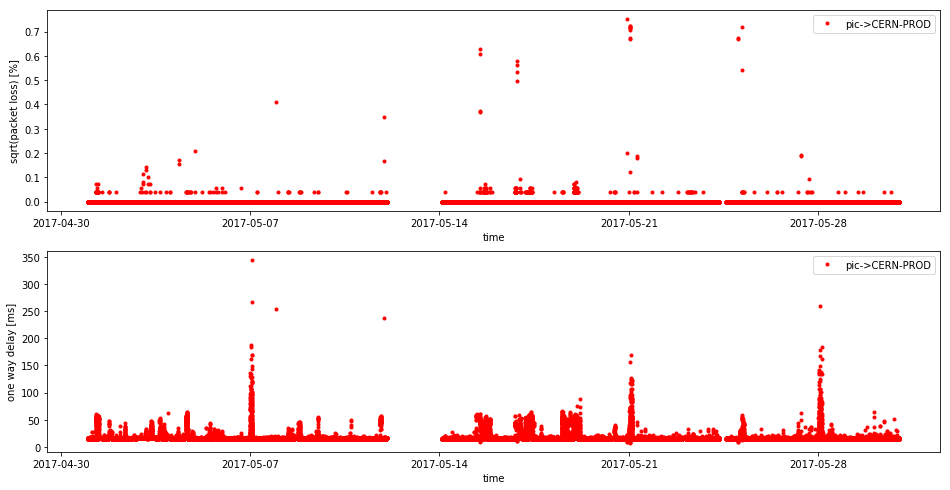

In [12]:
plt.figure(figsize=[16, 17])
gs = gridspec.GridSpec(4, 1)

ax2 = plt.subplot(gs[1])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()

ax4 = plt.subplot(gs[2])
ax4.plot(Fd.timestamp.tolist(), Fd.delay_mean.tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax4.set_xlabel('time')
ax4.set_ylabel('one way delay [ms]')
ax4.legend()

plt.show()

### Boosted Decision Trees

In [13]:
start_time = time.clock()

# predicted_flag_array = np.zeros((24*3600), dtype=np.int)
# auc_score_array = np.zeros((24*3600), dtype=np.float)
# score_holder_array = np.zeros(3600, dtype=np.float)
# anomaly_array = np.ones(3600, dtype=np.int)
# not_anomaly_array = np.zeros(3600, dtype=np.int)

In [14]:
n_series = 1
start_date = '2017-05-01 00:00:00'
end_date = '2017-05-31 23:59:59'

window = 24

In [15]:
def check_for_anomaly(ref, sub):
    
    y_ref = pd.Series([0] * ref.shape[0])
    X_ref = ref
    del X_ref['auc_score']
    
    y_sub = pd.Series([1] * sub.shape[0])
    X_sub=sub
    del X_sub['auc_score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=50)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=50)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    clf = AdaBoostClassifier(n_estimators=50)
    
    #train an AdaBoost model to be able to tell the difference between the reference and subject data
    clf.fit(X_train, y_train) 

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    
    # scores = cross_val_score(clf, X, y)
    # print(scores)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    print ( "auc_score = ", auc_score, "\tfeature importances:", clf.feature_importances_)
    
    if auc_score > 0.55: 
        plot_roc(fpr, tpr, auc_score)
        #filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
        #tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
        #tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return auc_score

In [16]:
def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [17]:
start_date = Fpl['timestamp'].min()
print(start_date)
end_date = Fpl['timestamp'].max()
print(end_date)

#print(Fpl.index/1000 - 1502668800.0)

Fpl2 = Fpl.set_index('timestamp')
Fpl2['auc_score']=0.5
print(Fpl2)

2017-05-01 00:00:04
2017-05-30 23:59:55
                     delay_median  delay_mean   delay_sd  packet_loss  \
timestamp                                                               
2017-05-01 00:00:04        15.240   15.304733   0.601748          0.0   
2017-05-01 00:00:42        15.210   15.268967   0.394805          0.0   
2017-05-01 00:01:04        15.190   15.243600   0.555692          0.0   
2017-05-01 00:01:42        22.765   15.218700   0.361329          0.0   
2017-05-01 00:02:04        15.180   15.890533   9.572120          0.0   
2017-05-01 00:02:42        15.170   15.190917   0.106413          0.0   
2017-05-01 00:03:04        15.180   15.206683   0.162078          0.0   
2017-05-01 00:03:42        15.200   16.087383  14.567939          0.0   
2017-05-01 00:04:04        15.180   15.202983   0.086500          0.0   
2017-05-01 00:04:42        15.200   15.229767   0.203868          0.0   
2017-05-01 00:05:04        15.200   15.216250   0.146410          0.0   
2017-05-01 

In [18]:
print(Fpl2.index)

DatetimeIndex(['2017-05-01 00:00:04', '2017-05-01 00:00:42',
               '2017-05-01 00:01:04', '2017-05-01 00:01:42',
               '2017-05-01 00:02:04', '2017-05-01 00:02:42',
               '2017-05-01 00:03:04', '2017-05-01 00:03:42',
               '2017-05-01 00:04:04', '2017-05-01 00:04:42',
               ...
               '2017-05-30 23:55:01', '2017-05-30 23:55:55',
               '2017-05-30 23:56:02', '2017-05-30 23:56:55',
               '2017-05-30 23:57:02', '2017-05-30 23:57:55',
               '2017-05-30 23:58:02', '2017-05-30 23:58:55',
               '2017-05-30 23:59:02', '2017-05-30 23:59:55'],
              dtype='datetime64[ns]', name='timestamp', length=79633, freq=None)


timestamp =  2017-05-02 00:00:04
auc_score =  0.499410377358 	feature importances: [ 0.24  0.5   0.26  0.  ]
timestamp =  2017-05-02 01:00:04
auc_score =  0.497051886792 	feature importances: [ 0.24  0.38  0.38  0.  ]
timestamp =  2017-05-02 02:00:04
auc_score =  0.5 	feature importances: [ 0.36  0.42  0.22  0.  ]
timestamp =  2017-05-02 03:00:04
auc_score =  0.499410377358 	feature importances: [ 0.24  0.34  0.42  0.  ]
timestamp =  2017-05-02 04:00:04
auc_score =  0.499410377358 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-02 05:00:04
auc_score =  0.498218527316 	feature importances: [ 0.34  0.4   0.26  0.  ]
timestamp =  2017-05-02 06:00:04
auc_score =  0.499404761905 	feature importances: [ 0.26  0.38  0.36  0.  ]
timestamp =  2017-05-02 07:00:04
auc_score =  0.495232419547 	feature importances: [ 0.32  0.32  0.36  0.  ]
timestamp =  2017-05-02 08:00:04
auc_score =  0.498808104887 	feature importances: [ 0.32  0.38  0.3   0.  ]
timestamp =  2017-05-02 09:00:

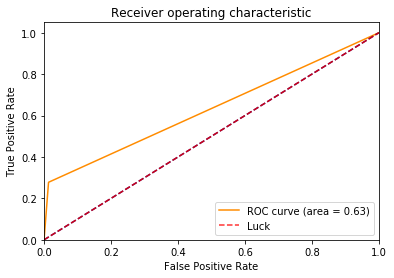

timestamp =  2017-05-02 16:00:04
auc_score =  0.812769687163 	feature importances: [ 0.2   0.28  0.52  0.  ]


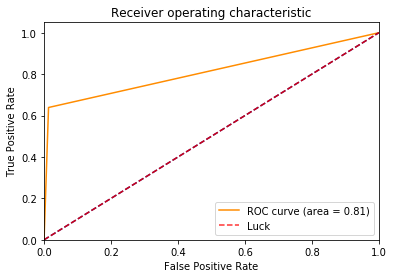

timestamp =  2017-05-02 17:00:04
auc_score =  0.704692556634 	feature importances: [ 0.46  0.32  0.22  0.  ]


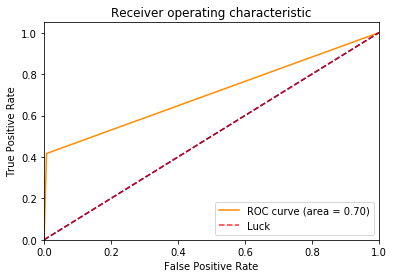

timestamp =  2017-05-02 18:00:04
auc_score =  0.952878787879 	feature importances: [ 0.38  0.38  0.24  0.  ]


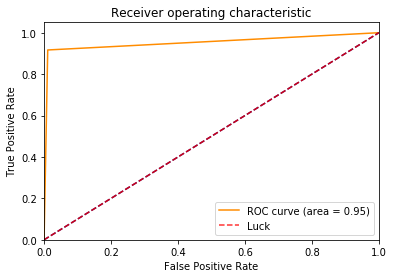

timestamp =  2017-05-02 19:00:04
auc_score =  0.687162891046 	feature importances: [ 0.54  0.18  0.28  0.  ]


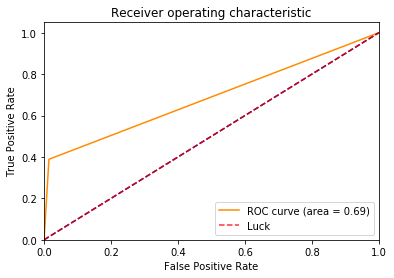

timestamp =  2017-05-02 20:00:04
auc_score =  0.707619047619 	feature importances: [ 0.16  0.44  0.4   0.  ]


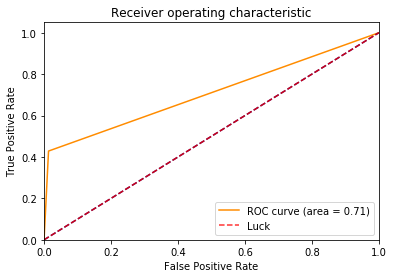

timestamp =  2017-05-02 21:00:04
auc_score =  0.714512901151 	feature importances: [ 0.34  0.32  0.34  0.  ]


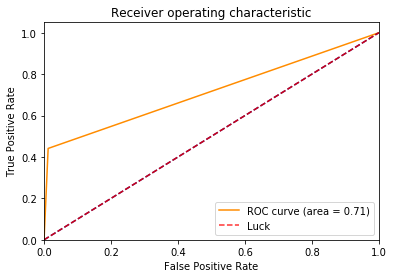

timestamp =  2017-05-02 22:00:04
auc_score =  0.729403794038 	feature importances: [ 0.36  0.4   0.22  0.02]


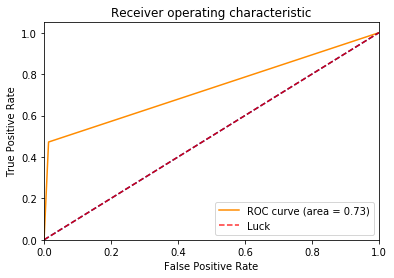

timestamp =  2017-05-02 23:00:04
auc_score =  0.661178861789 	feature importances: [ 0.34  0.32  0.32  0.02]


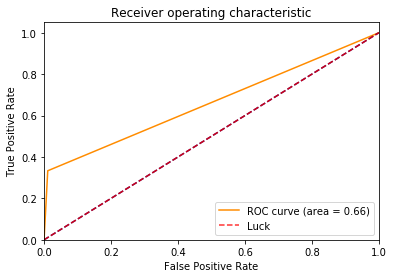

timestamp =  2017-05-03 00:00:04
auc_score =  0.509620596206 	feature importances: [ 0.2   0.5   0.28  0.02]
timestamp =  2017-05-03 01:00:04
auc_score =  0.511236933798 	feature importances: [ 0.44  0.4   0.16  0.  ]
timestamp =  2017-05-03 02:00:04
auc_score =  0.611233211233 	feature importances: [ 0.64  0.16  0.2   0.  ]


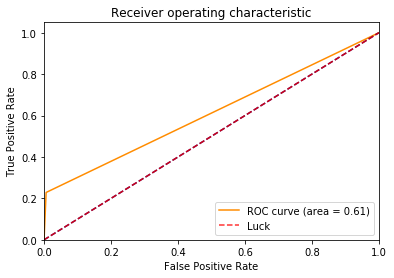

timestamp =  2017-05-03 03:00:04
auc_score =  0.591109752785 	feature importances: [ 0.2   0.38  0.4   0.02]


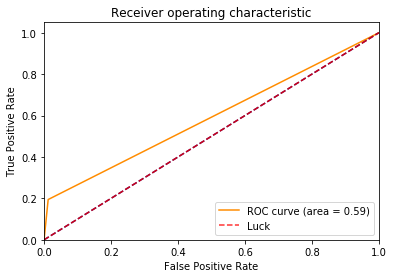

timestamp =  2017-05-03 04:00:04
auc_score =  0.52655528389 	feature importances: [ 0.34  0.32  0.34  0.  ]
timestamp =  2017-05-03 05:00:04
auc_score =  0.536818181818 	feature importances: [ 0.44  0.24  0.3   0.02]
timestamp =  2017-05-03 06:00:04
auc_score =  0.55313717587 	feature importances: [ 0.32  0.36  0.32  0.  ]


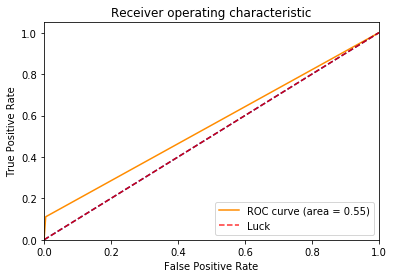

timestamp =  2017-05-03 07:00:04
auc_score =  0.538647342995 	feature importances: [ 0.52  0.28  0.2   0.  ]
timestamp =  2017-05-03 08:00:04
auc_score =  0.777600170503 	feature importances: [ 0.12  0.44  0.42  0.02]


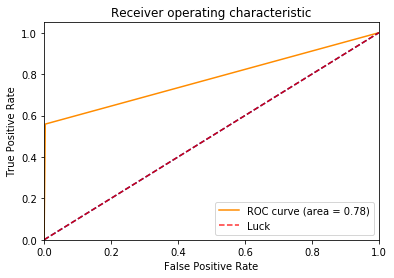

timestamp =  2017-05-03 09:00:04
auc_score =  0.515018939394 	feature importances: [ 0.36  0.2   0.44  0.  ]
timestamp =  2017-05-03 10:00:04
auc_score =  0.513621599675 	feature importances: [ 0.3  0.4  0.3  0. ]
timestamp =  2017-05-03 11:00:04
auc_score =  0.510618232623 	feature importances: [ 0.34  0.28  0.36  0.02]
timestamp =  2017-05-03 12:00:04
auc_score =  0.638888888889 	feature importances: [ 0.44  0.32  0.24  0.  ]


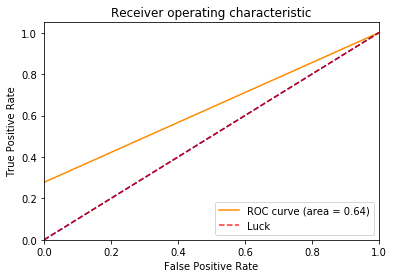

timestamp =  2017-05-03 13:00:04
auc_score =  0.870833333333 	feature importances: [ 0.46  0.4   0.14  0.  ]


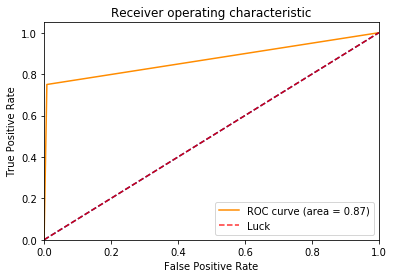

timestamp =  2017-05-03 14:00:04
auc_score =  0.914880952381 	feature importances: [ 0.44  0.34  0.22  0.  ]


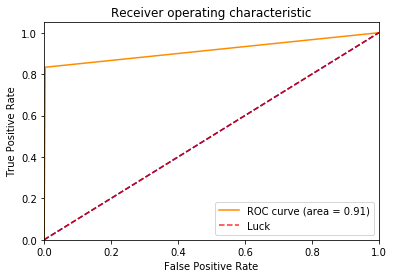

timestamp =  2017-05-03 15:00:04
auc_score =  0.729563492063 	feature importances: [ 0.4   0.42  0.18  0.  ]


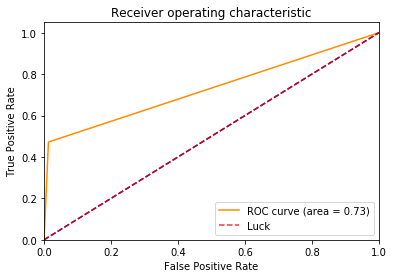

timestamp =  2017-05-03 16:00:04
auc_score =  0.579761904762 	feature importances: [ 0.5   0.16  0.34  0.  ]


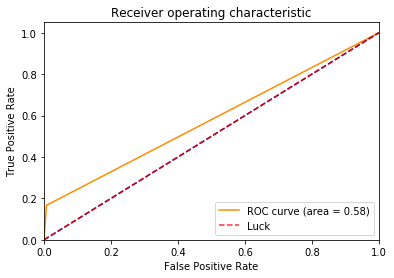

timestamp =  2017-05-03 17:00:04
auc_score =  0.552579365079 	feature importances: [ 0.5   0.24  0.26  0.  ]


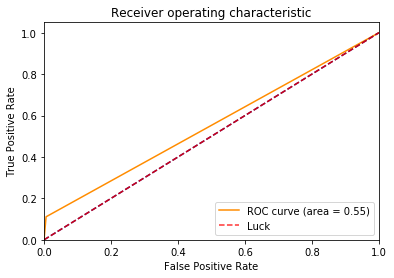

timestamp =  2017-05-03 18:00:04
auc_score =  0.593055555556 	feature importances: [ 0.46  0.36  0.18  0.  ]


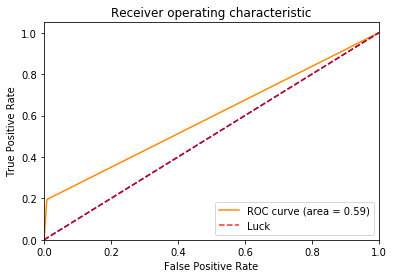

timestamp =  2017-05-03 19:00:04
auc_score =  0.593650793651 	feature importances: [ 0.56  0.22  0.22  0.  ]


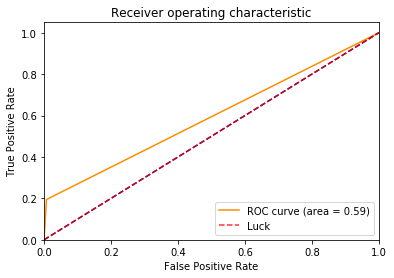

timestamp =  2017-05-03 20:00:04
auc_score =  0.580357142857 	feature importances: [ 0.32  0.32  0.36  0.  ]


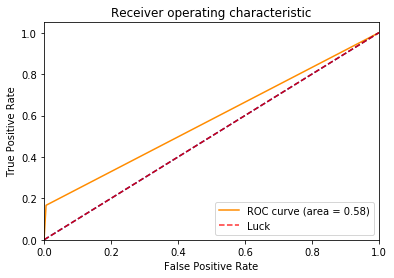

timestamp =  2017-05-03 21:00:04
auc_score =  0.554961731328 	feature importances: [ 0.38  0.32  0.3   0.  ]


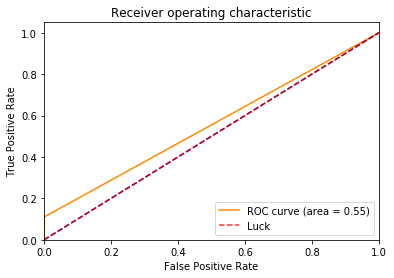

timestamp =  2017-05-03 22:00:04
auc_score =  0.826224328594 	feature importances: [ 0.18  0.46  0.36  0.  ]


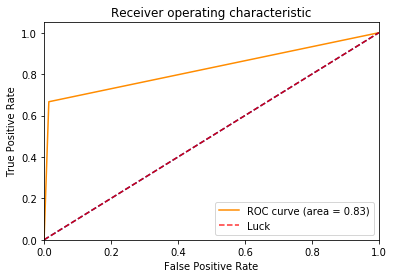

timestamp =  2017-05-03 23:00:04
auc_score =  0.678012863913 	feature importances: [ 0.32  0.4   0.28  0.  ]


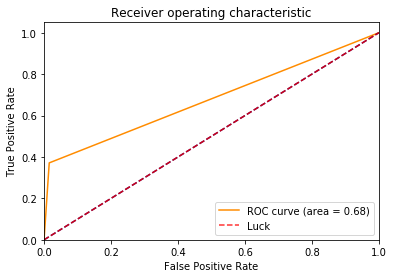

timestamp =  2017-05-04 00:00:04
auc_score =  0.564705107952 	feature importances: [ 0.38  0.32  0.3   0.  ]


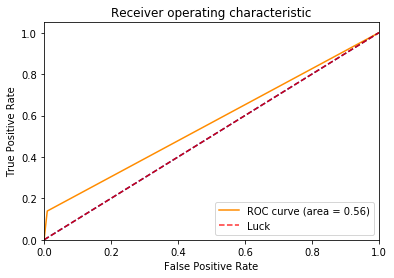

timestamp =  2017-05-04 01:00:04
auc_score =  0.525408109531 	feature importances: [ 0.3   0.36  0.34  0.  ]
timestamp =  2017-05-04 02:00:04
auc_score =  0.705374753452 	feature importances: [ 0.38  0.4   0.22  0.  ]


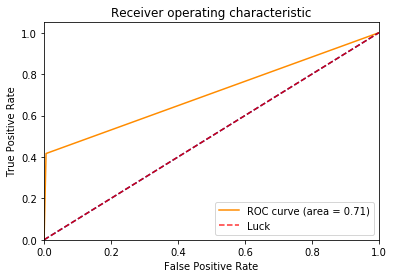

timestamp =  2017-05-04 03:00:04
auc_score =  0.72901891253 	feature importances: [ 0.36  0.38  0.26  0.  ]


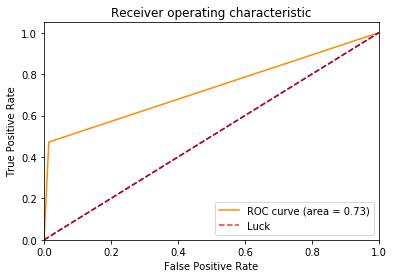

timestamp =  2017-05-04 04:00:04
auc_score =  0.604609929078 	feature importances: [ 0.32  0.34  0.34  0.  ]


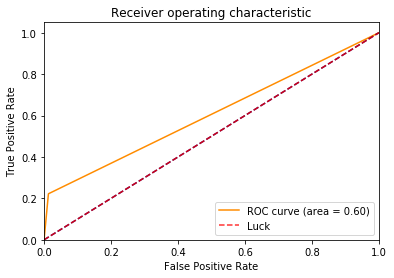

timestamp =  2017-05-04 05:00:04
auc_score =  0.523640661939 	feature importances: [ 0.28  0.38  0.34  0.  ]
timestamp =  2017-05-04 06:00:04
auc_score =  0.533392434988 	feature importances: [ 0.3   0.36  0.34  0.  ]
timestamp =  2017-05-04 07:00:04
auc_score =  0.526004728132 	feature importances: [ 0.28  0.36  0.36  0.  ]
timestamp =  2017-05-04 08:00:04
auc_score =  0.513888888889 	feature importances: [ 0.36  0.28  0.34  0.02]
timestamp =  2017-05-04 09:00:04
auc_score =  0.60285639413 	feature importances: [ 0.38  0.38  0.24  0.  ]


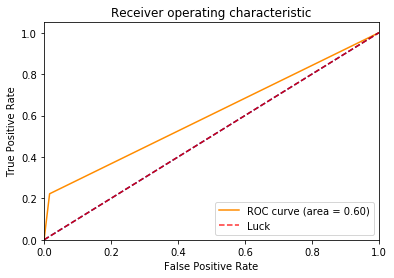

timestamp =  2017-05-04 10:00:04
auc_score =  0.49941314554 	feature importances: [ 0.4  0.3  0.3  0. ]
timestamp =  2017-05-04 11:00:04
auc_score =  0.498835855646 	feature importances: [ 0.44  0.36  0.2   0.  ]
timestamp =  2017-05-04 12:00:04
auc_score =  0.497674418605 	feature importances: [ 0.4   0.32  0.28  0.  ]
timestamp =  2017-05-04 13:00:04
auc_score =  0.499418604651 	feature importances: [ 0.3   0.42  0.28  0.  ]
timestamp =  2017-05-04 14:00:04
auc_score =  0.5 	feature importances: [ 0.3   0.36  0.34  0.  ]
timestamp =  2017-05-04 15:00:04
auc_score =  0.899289405685 	feature importances: [ 0.28  0.36  0.36  0.  ]


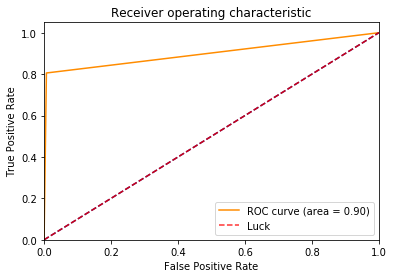

timestamp =  2017-05-04 16:00:04
auc_score =  0.523126614987 	feature importances: [ 0.38  0.38  0.24  0.  ]
timestamp =  2017-05-04 17:00:04
auc_score =  0.759237726098 	feature importances: [ 0.3   0.38  0.32  0.  ]


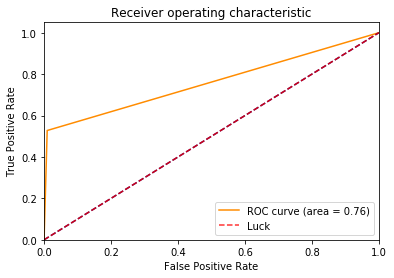

timestamp =  2017-05-04 18:00:04
auc_score =  0.511563307494 	feature importances: [ 0.58  0.28  0.14  0.  ]
timestamp =  2017-05-04 19:00:04
auc_score =  0.497674418605 	feature importances: [ 0.4   0.36  0.24  0.  ]
timestamp =  2017-05-04 20:00:04
auc_score =  0.565374677003 	feature importances: [ 0.42  0.3   0.28  0.  ]


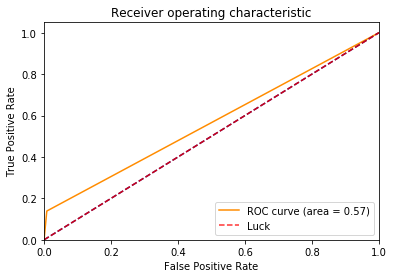

timestamp =  2017-05-04 21:00:04
auc_score =  0.499418604651 	feature importances: [ 0.5   0.34  0.16  0.  ]
timestamp =  2017-05-04 22:00:04
auc_score =  0.53992248062 	feature importances: [ 0.34  0.38  0.28  0.  ]
timestamp =  2017-05-04 23:00:04
auc_score =  0.5 	feature importances: [ 0.3   0.38  0.32  0.  ]
timestamp =  2017-05-05 00:00:04
auc_score =  0.5 	feature importances: [ 0.42  0.36  0.22  0.  ]
timestamp =  2017-05-05 01:00:04
auc_score =  0.525923392613 	feature importances: [ 0.28  0.36  0.36  0.  ]
timestamp =  2017-05-05 02:00:04
auc_score =  0.510396455827 	feature importances: [ 0.38  0.4   0.22  0.  ]
timestamp =  2017-05-05 03:00:04
auc_score =  0.523115773116 	feature importances: [ 0.36  0.3   0.34  0.  ]
timestamp =  2017-05-05 04:00:04
auc_score =  0.497086247086 	feature importances: [ 0.34  0.28  0.38  0.  ]
timestamp =  2017-05-05 05:00:04
auc_score =  0.499413833529 	feature importances: [ 0.3   0.54  0.16  0.  ]
timestamp =  2017-05-05 06:00:04
auc_score

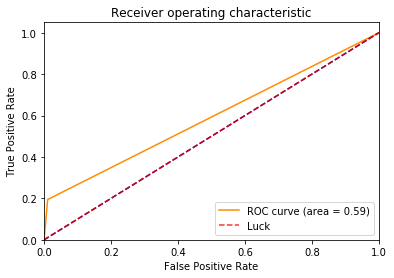

timestamp =  2017-05-05 11:00:04
auc_score =  0.499405469679 	feature importances: [ 0.28  0.46  0.26  0.  ]
timestamp =  2017-05-05 12:00:04
auc_score =  0.512699828247 	feature importances: [ 0.44  0.2   0.36  0.  ]
timestamp =  2017-05-05 13:00:04
auc_score =  0.524805126173 	feature importances: [ 0.4   0.32  0.28  0.  ]
timestamp =  2017-05-05 14:00:04
auc_score =  0.524805126173 	feature importances: [ 0.42  0.3   0.28  0.  ]
timestamp =  2017-05-05 15:00:04
auc_score =  0.498810939358 	feature importances: [ 0.48  0.3   0.22  0.  ]
timestamp =  2017-05-05 16:00:04
auc_score =  0.640030469679 	feature importances: [ 0.24  0.48  0.28  0.  ]


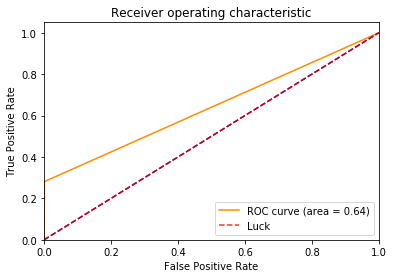

timestamp =  2017-05-05 17:00:04
auc_score =  0.511496544391 	feature importances: [ 0.34  0.34  0.32  0.  ]
timestamp =  2017-05-05 18:00:04
auc_score =  0.497607655502 	feature importances: [ 0.54  0.24  0.22  0.  ]
timestamp =  2017-05-05 19:00:04
auc_score =  0.511496544391 	feature importances: [ 0.54  0.3   0.16  0.  ]
timestamp =  2017-05-05 20:00:04
auc_score =  0.497607655502 	feature importances: [ 0.36  0.38  0.26  0.  ]
timestamp =  2017-05-05 21:00:04
auc_score =  0.533891547049 	feature importances: [ 0.46  0.28  0.26  0.  ]
timestamp =  2017-05-05 22:00:04
auc_score =  0.609914938862 	feature importances: [ 0.46  0.38  0.16  0.  ]


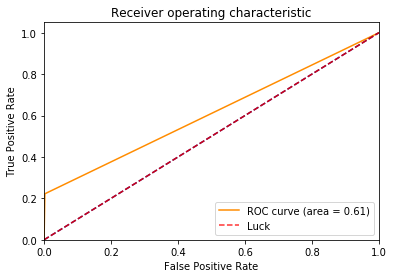

timestamp =  2017-05-05 23:00:04
auc_score =  0.5 	feature importances: [ 0.42  0.2   0.38  0.  ]
timestamp =  2017-05-06 00:00:04
auc_score =  0.553761297182 	feature importances: [ 0.24  0.36  0.4   0.  ]


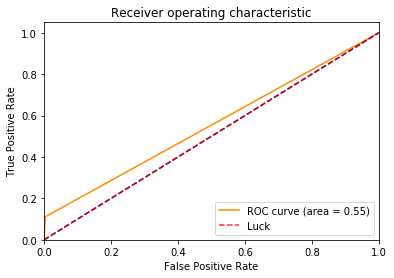

timestamp =  2017-05-06 01:00:04
auc_score =  0.541725302561 	feature importances: [ 0.34  0.38  0.28  0.  ]
timestamp =  2017-05-06 02:00:04
auc_score =  0.49880239521 	feature importances: [ 0.62  0.3   0.08  0.  ]
timestamp =  2017-05-06 03:00:04
auc_score =  0.51269271664 	feature importances: [ 0.32  0.38  0.3   0.  ]
timestamp =  2017-05-06 04:00:04
auc_score =  0.510300372142 	feature importances: [ 0.38  0.36  0.26  0.  ]
timestamp =  2017-05-06 05:00:04
auc_score =  0.510317460317 	feature importances: [ 0.34  0.38  0.28  0.  ]
timestamp =  2017-05-06 06:00:04
auc_score =  0.526605444835 	feature importances: [ 0.42  0.24  0.34  0.  ]
timestamp =  2017-05-06 07:00:04
auc_score =  0.581574833919 	feature importances: [ 0.36  0.44  0.2   0.  ]


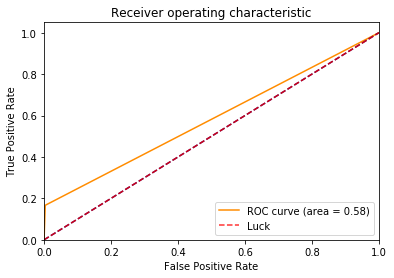

timestamp =  2017-05-06 08:00:04
auc_score =  0.534632669011 	feature importances: [ 0.34  0.42  0.24  0.  ]
timestamp =  2017-05-06 09:00:04
auc_score =  0.5 	feature importances: [ 0.22  0.26  0.52  0.  ]
timestamp =  2017-05-06 10:00:04
auc_score =  0.540494333724 	feature importances: [ 0.46  0.32  0.22  0.  ]
timestamp =  2017-05-06 11:00:04
auc_score =  0.5 	feature importances: [ 0.3   0.28  0.42  0.  ]
timestamp =  2017-05-06 12:00:04
auc_score =  0.498827667057 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-06 13:00:04
auc_score =  0.513302722418 	feature importances: [ 0.36  0.3   0.34  0.  ]
timestamp =  2017-05-06 14:00:04
auc_score =  0.538149667839 	feature importances: [ 0.4  0.4  0.2  0. ]
timestamp =  2017-05-06 15:00:04
auc_score =  0.5 	feature importances: [ 0.4   0.32  0.28  0.  ]
timestamp =  2017-05-06 16:00:04
auc_score =  0.512716555946 	feature importances: [ 0.38  0.22  0.4   0.  ]
timestamp =  2017-05-06 17:00:04
auc_score =  0.49883449

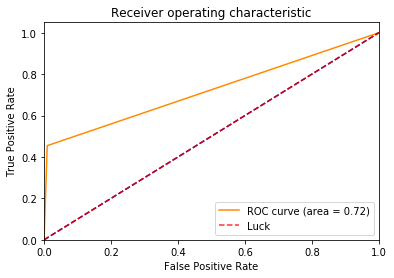

timestamp =  2017-05-07 00:00:04
auc_score =  0.955395613004 	feature importances: [ 0.34  0.36  0.3   0.  ]


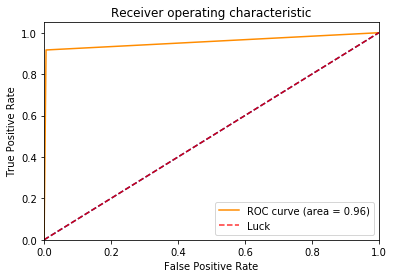

timestamp =  2017-05-07 01:00:04
auc_score =  0.912523082088 	feature importances: [ 0.5   0.22  0.28  0.  ]


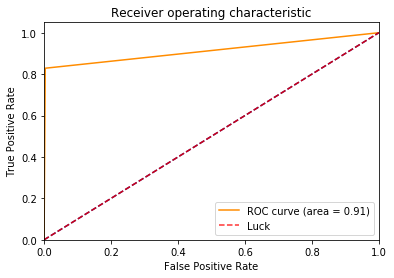

timestamp =  2017-05-07 02:00:04
auc_score =  0.49882629108 	feature importances: [ 0.38  0.34  0.28  0.  ]
timestamp =  2017-05-07 03:00:04
auc_score =  0.49882629108 	feature importances: [ 0.34  0.44  0.22  0.  ]
timestamp =  2017-05-07 04:00:04
auc_score =  0.512715179969 	feature importances: [ 0.3   0.26  0.44  0.  ]
timestamp =  2017-05-07 05:00:04
auc_score =  0.510367762128 	feature importances: [ 0.32  0.24  0.44  0.  ]
timestamp =  2017-05-07 06:00:04
auc_score =  0.496478873239 	feature importances: [ 0.38  0.2   0.42  0.  ]
timestamp =  2017-05-07 07:00:04
auc_score =  0.512130389475 	feature importances: [ 0.38  0.38  0.24  0.  ]
timestamp =  2017-05-07 08:00:04
auc_score =  0.551861167002 	feature importances: [ 0.28  0.24  0.48  0.  ]


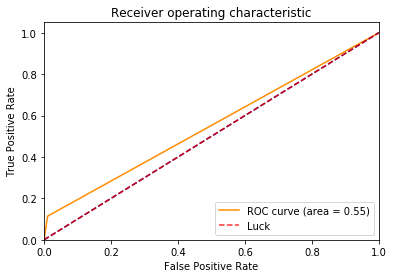

timestamp =  2017-05-07 09:00:04
auc_score =  0.498237367803 	feature importances: [ 0.14  0.5   0.36  0.  ]
timestamp =  2017-05-07 10:00:04
auc_score =  0.562981459721 	feature importances: [ 0.46  0.38  0.16  0.  ]


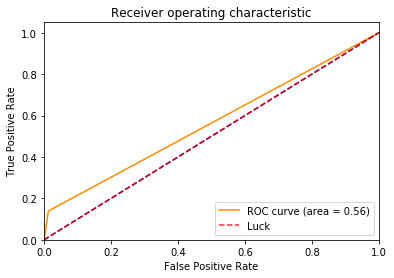

timestamp =  2017-05-07 11:00:04
auc_score =  0.498235294118 	feature importances: [ 0.5   0.32  0.18  0.  ]
timestamp =  2017-05-07 12:00:04
auc_score =  0.498823529412 	feature importances: [ 0.4   0.34  0.26  0.  ]
timestamp =  2017-05-07 13:00:04
auc_score =  0.5 	feature importances: [ 0.36  0.44  0.2   0.  ]
timestamp =  2017-05-07 14:00:04
auc_score =  0.526013071895 	feature importances: [ 0.36  0.32  0.32  0.  ]
timestamp =  2017-05-07 15:00:04
auc_score =  0.497649823737 	feature importances: [ 0.26  0.48  0.26  0.  ]
timestamp =  2017-05-07 16:00:04
auc_score =  0.498237367803 	feature importances: [ 0.24  0.36  0.4   0.  ]
timestamp =  2017-05-07 17:00:04
auc_score =  0.552617835227 	feature importances: [ 0.22  0.46  0.32  0.  ]


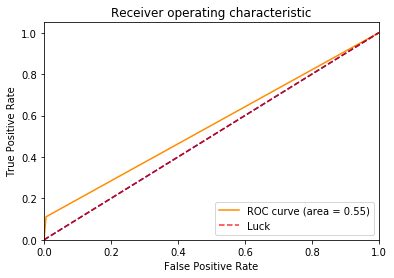

timestamp =  2017-05-07 18:00:04
auc_score =  0.497647058824 	feature importances: [ 0.56  0.16  0.28  0.  ]
timestamp =  2017-05-07 19:00:04
auc_score =  0.652189542484 	feature importances: [ 0.44  0.26  0.3   0.  ]


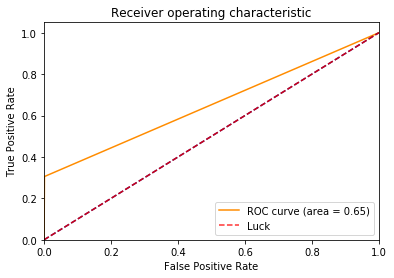

timestamp =  2017-05-07 20:00:04
auc_score =  0.645718954248 	feature importances: [ 0.44  0.32  0.24  0.  ]


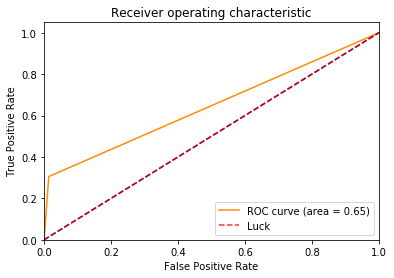

timestamp =  2017-05-07 21:00:04
auc_score =  0.70598315707 	feature importances: [ 0.3  0.4  0.3  0. ]


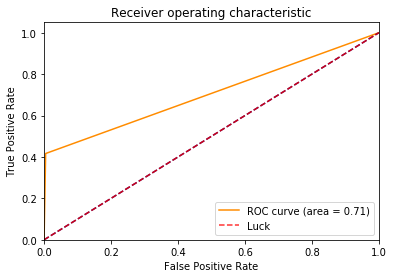

timestamp =  2017-05-07 22:00:04
auc_score =  0.744131455399 	feature importances: [ 0.48  0.32  0.2   0.  ]


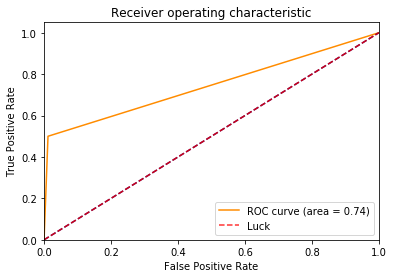

timestamp =  2017-05-07 23:00:04
auc_score =  0.49941588785 	feature importances: [ 0.42  0.24  0.34  0.  ]
timestamp =  2017-05-08 00:00:04
auc_score =  0.497668997669 	feature importances: [ 0.5   0.24  0.26  0.  ]
timestamp =  2017-05-08 01:00:04
auc_score =  0.5 	feature importances: [ 0.44  0.34  0.2   0.02]
timestamp =  2017-05-08 02:00:04
auc_score =  0.498251748252 	feature importances: [ 0.42  0.24  0.34  0.  ]
timestamp =  2017-05-08 03:00:04
auc_score =  0.537004662005 	feature importances: [ 0.32  0.46  0.22  0.  ]
timestamp =  2017-05-08 04:00:04
auc_score =  0.498834498834 	feature importances: [ 0.48  0.2   0.32  0.  ]
timestamp =  2017-05-08 05:00:04
auc_score =  0.499417249417 	feature importances: [ 0.44  0.36  0.2   0.  ]
timestamp =  2017-05-08 06:00:04
auc_score =  0.498251748252 	feature importances: [ 0.36  0.34  0.3   0.  ]
timestamp =  2017-05-08 07:00:04
auc_score =  0.513306138306 	feature importances: [ 0.38  0.42  0.2   0.  ]
timestamp =  2017-05-08 08:00:0

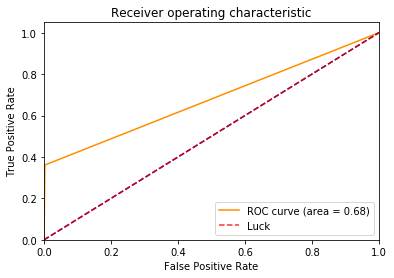

timestamp =  2017-05-08 10:00:04
auc_score =  0.537015503876 	feature importances: [ 0.4   0.32  0.28  0.  ]
timestamp =  2017-05-08 11:00:04
auc_score =  0.513308168796 	feature importances: [ 0.38  0.24  0.38  0.  ]
timestamp =  2017-05-08 12:00:04
auc_score =  0.579849012776 	feature importances: [ 0.5   0.28  0.22  0.  ]


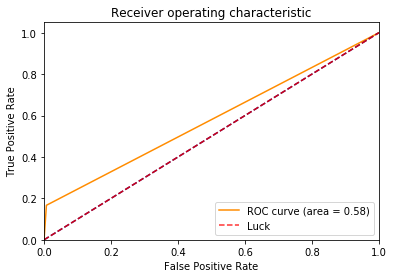

timestamp =  2017-05-08 13:00:04
auc_score =  0.526616337592 	feature importances: [ 0.5   0.22  0.28  0.  ]
timestamp =  2017-05-08 14:00:04
auc_score =  0.510404568331 	feature importances: [ 0.4  0.3  0.3  0. ]
timestamp =  2017-05-08 15:00:04
auc_score =  0.602400309717 	feature importances: [ 0.32  0.32  0.36  0.  ]


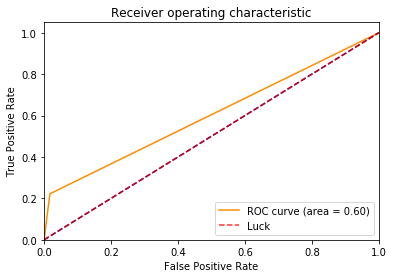

timestamp =  2017-05-08 16:00:04
auc_score =  0.523712737127 	feature importances: [ 0.24  0.44  0.32  0.  ]
timestamp =  2017-05-08 17:00:04
auc_score =  0.594315245478 	feature importances: [ 0.2   0.34  0.46  0.  ]


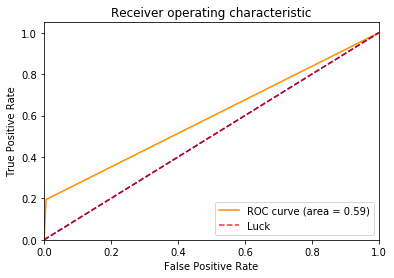

timestamp =  2017-05-08 18:00:04
auc_score =  0.609059233449 	feature importances: [ 0.38  0.32  0.3   0.  ]


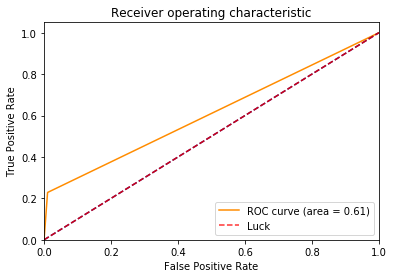

timestamp =  2017-05-08 19:00:04
auc_score =  0.567936138367 	feature importances: [ 0.54  0.24  0.22  0.  ]


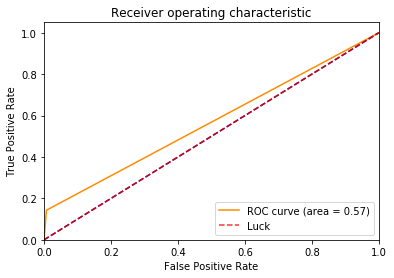

timestamp =  2017-05-08 20:00:04
auc_score =  0.536421911422 	feature importances: [ 0.36  0.34  0.3   0.  ]
timestamp =  2017-05-08 21:00:04
auc_score =  0.554972804973 	feature importances: [ 0.44  0.34  0.22  0.  ]


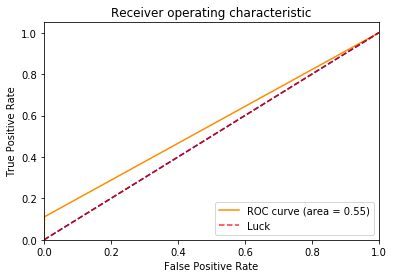

timestamp =  2017-05-08 22:00:04
auc_score =  0.523698523699 	feature importances: [ 0.28  0.4   0.32  0.  ]
timestamp =  2017-05-08 23:00:04
auc_score =  0.498251748252 	feature importances: [ 0.26  0.38  0.36  0.  ]
timestamp =  2017-05-09 00:00:04
auc_score =  0.50980963481 	feature importances: [ 0.36  0.3   0.34  0.  ]
timestamp =  2017-05-09 01:00:04
auc_score =  0.566530691531 	feature importances: [ 0.38  0.38  0.24  0.  ]


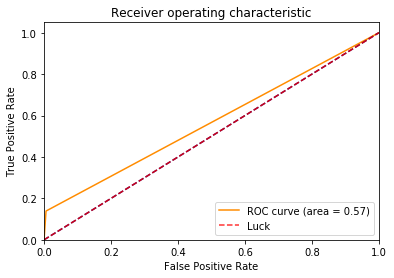

timestamp =  2017-05-09 02:00:04
auc_score =  0.498249708285 	feature importances: [ 0.6  0.2  0.2  0. ]
timestamp =  2017-05-09 03:00:04
auc_score =  0.535832360949 	feature importances: [ 0.3   0.34  0.36  0.  ]
timestamp =  2017-05-09 04:00:04
auc_score =  0.498833138856 	feature importances: [ 0.42  0.32  0.26  0.  ]
timestamp =  2017-05-09 05:00:04
auc_score =  0.498833138856 	feature importances: [ 0.4   0.34  0.26  0.  ]
timestamp =  2017-05-09 06:00:04
auc_score =  0.499416569428 	feature importances: [ 0.42  0.24  0.34  0.  ]
timestamp =  2017-05-09 07:00:04
auc_score =  0.512722027745 	feature importances: [ 0.34  0.3   0.36  0.  ]
timestamp =  2017-05-09 08:00:04
auc_score =  0.497666277713 	feature importances: [ 0.3   0.38  0.32  0.  ]
timestamp =  2017-05-09 09:00:04
auc_score =  0.498833138856 	feature importances: [ 0.4   0.38  0.22  0.  ]
timestamp =  2017-05-09 10:00:04
auc_score =  0.5 	feature importances: [ 0.38  0.24  0.38  0.  ]
timestamp =  2017-05-09 11:00:04
a

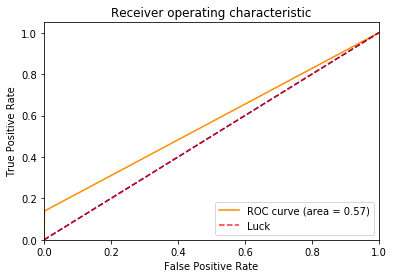

timestamp =  2017-05-09 13:00:04
auc_score =  0.5 	feature importances: [ 0.28  0.4   0.32  0.  ]
timestamp =  2017-05-09 14:00:04
auc_score =  0.499416569428 	feature importances: [ 0.5   0.22  0.28  0.  ]
timestamp =  2017-05-09 15:00:04
auc_score =  0.526610916634 	feature importances: [ 0.44  0.34  0.22  0.  ]
timestamp =  2017-05-09 16:00:04
auc_score =  0.495332555426 	feature importances: [ 0.32  0.26  0.42  0.  ]
timestamp =  2017-05-09 17:00:04
auc_score =  0.498249708285 	feature importances: [ 0.46  0.3   0.24  0.  ]
timestamp =  2017-05-09 18:00:04
auc_score =  0.527194347206 	feature importances: [ 0.28  0.36  0.36  0.  ]
timestamp =  2017-05-09 19:00:04
auc_score =  0.616850989523 	feature importances: [ 0.46  0.24  0.3   0.  ]


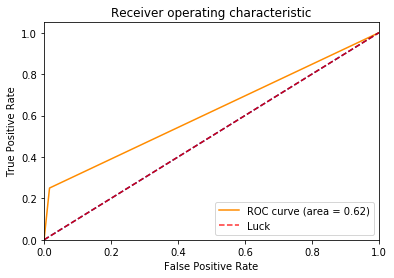

timestamp =  2017-05-09 20:00:04
auc_score =  0.510985288424 	feature importances: [ 0.3   0.32  0.38  0.  ]
timestamp =  2017-05-09 21:00:04
auc_score =  0.498255813953 	feature importances: [ 0.46  0.36  0.18  0.  ]
timestamp =  2017-05-09 22:00:04
auc_score =  0.5 	feature importances: [ 0.7   0.24  0.06  0.  ]
timestamp =  2017-05-09 23:00:04
auc_score =  0.514285714286 	feature importances: [ 0.36  0.34  0.3   0.  ]
timestamp =  2017-05-10 00:00:04
auc_score =  0.5 	feature importances: [ 0.5   0.26  0.24  0.  ]
timestamp =  2017-05-10 01:00:04
auc_score =  0.511566008517 	feature importances: [ 0.32  0.46  0.22  0.  ]
timestamp =  2017-05-10 02:00:04
auc_score =  0.498838559814 	feature importances: [ 0.44  0.3   0.26  0.  ]
timestamp =  2017-05-10 03:00:04
auc_score =  0.498838559814 	feature importances: [ 0.28  0.42  0.3   0.  ]
timestamp =  2017-05-10 04:00:04
auc_score =  0.498257839721 	feature importances: [ 0.18  0.4   0.42  0.  ]
timestamp =  2017-05-10 05:00:04
auc_scor

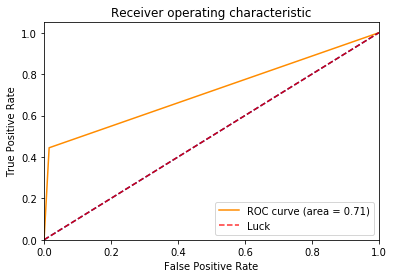

timestamp =  2017-05-10 07:00:04
auc_score =  0.512144702842 	feature importances: [ 0.48  0.26  0.26  0.  ]
timestamp =  2017-05-10 08:00:04
auc_score =  0.497674418605 	feature importances: [ 0.36  0.32  0.32  0.  ]
timestamp =  2017-05-10 09:00:04
auc_score =  0.498838559814 	feature importances: [ 0.26  0.56  0.18  0.  ]
timestamp =  2017-05-10 10:00:04
auc_score =  0.499419279907 	feature importances: [ 0.42  0.26  0.32  0.  ]
timestamp =  2017-05-10 11:00:04
auc_score =  0.5 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-10 12:00:04
auc_score =  0.589082687339 	feature importances: [ 0.26  0.22  0.52  0.  ]


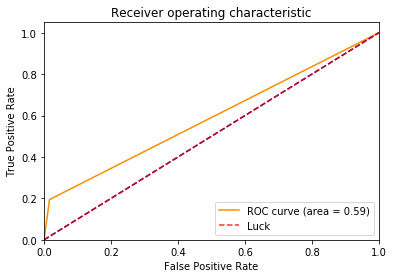

timestamp =  2017-05-10 13:00:04
auc_score =  0.513888888889 	feature importances: [ 0.52  0.2   0.26  0.02]
timestamp =  2017-05-10 14:00:04
auc_score =  0.732041343669 	feature importances: [ 0.38  0.46  0.16  0.  ]


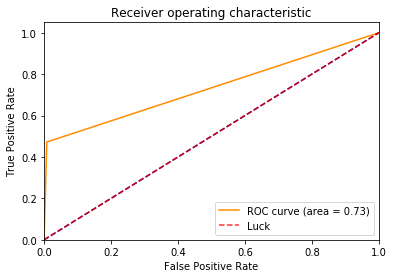

timestamp =  2017-05-10 15:00:04
auc_score =  0.651033591731 	feature importances: [ 0.5  0.3  0.2  0. ]


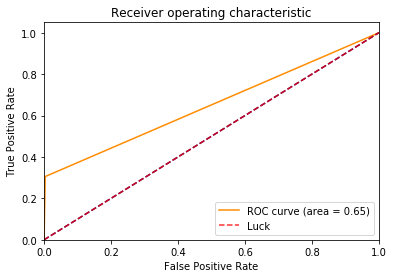

timestamp =  2017-05-10 16:00:04
auc_score =  0.524870801034 	feature importances: [ 0.46  0.32  0.22  0.  ]
timestamp =  2017-05-10 17:00:04
auc_score =  0.527196382429 	feature importances: [ 0.38  0.42  0.2   0.  ]
timestamp =  2017-05-10 18:00:04
auc_score =  0.497674418605 	feature importances: [ 0.36  0.32  0.32  0.  ]
timestamp =  2017-05-10 19:00:04
auc_score =  0.498837209302 	feature importances: [ 0.34  0.38  0.28  0.  ]
timestamp =  2017-05-10 20:00:04
auc_score =  0.513888888889 	feature importances: [ 0.4   0.32  0.28  0.  ]
timestamp =  2017-05-10 21:00:04
auc_score =  0.596059431525 	feature importances: [ 0.38  0.34  0.28  0.  ]


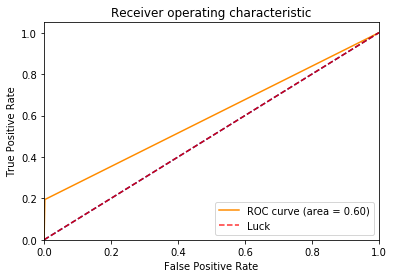

timestamp =  2017-05-10 22:00:04
auc_score =  0.554392764858 	feature importances: [ 0.58  0.24  0.18  0.  ]


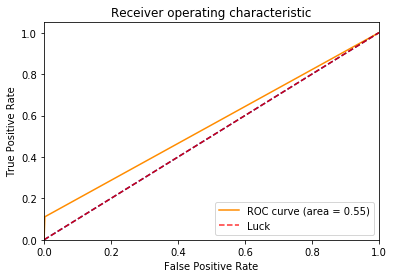

timestamp =  2017-05-10 23:00:04
auc_score =  0.5 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-11 00:00:04
auc_score =  0.498835855646 	feature importances: [ 0.34  0.24  0.42  0.  ]
timestamp =  2017-05-11 01:00:04
auc_score =  0.5 	feature importances: [ 0.34  0.32  0.34  0.  ]
timestamp =  2017-05-11 02:00:04
auc_score =  0.499418604651 	feature importances: [ 0.3  0.3  0.4  0. ]
timestamp =  2017-05-11 03:00:04
auc_score =  0.498255813953 	feature importances: [ 0.28  0.32  0.4   0.  ]
timestamp =  2017-05-11 04:00:04
auc_score =  0.513888888889 	feature importances: [ 0.26  0.42  0.32  0.  ]
timestamp =  2017-05-11 05:00:04
auc_score =  0.499418604651 	feature importances: [ 0.26  0.3   0.44  0.  ]
timestamp =  2017-05-11 06:00:04
auc_score =  0.51330749354 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-11 07:00:04
auc_score =  0.524870801034 	feature importances: [ 0.32  0.38  0.3   0.  ]
timestamp =  2017-05-11 08:00:04
auc_score =  

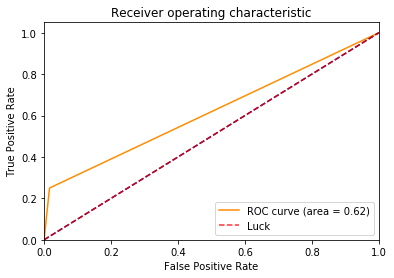

timestamp =  2017-05-11 13:00:04
auc_score =  0.5 	feature importances: [ 0.42  0.28  0.3   0.  ]
timestamp =  2017-05-11 14:00:04
auc_score =  0.498838559814 	feature importances: [ 0.46  0.28  0.26  0.  ]
timestamp =  2017-05-11 15:00:04
auc_score =  0.527197057685 	feature importances: [ 0.34  0.28  0.38  0.  ]
timestamp =  2017-05-11 16:00:04
auc_score =  0.499419279907 	feature importances: [ 0.5   0.24  0.26  0.  ]
timestamp =  2017-05-11 17:00:04
auc_score =  0.5 	feature importances: [ 0.32  0.3   0.38  0.  ]
timestamp =  2017-05-11 18:00:04
auc_score =  0.498838559814 	feature importances: [ 0.4   0.38  0.22  0.  ]
timestamp =  2017-05-11 19:00:04
auc_score =  0.706591173055 	feature importances: [ 0.38  0.3   0.32  0.  ]


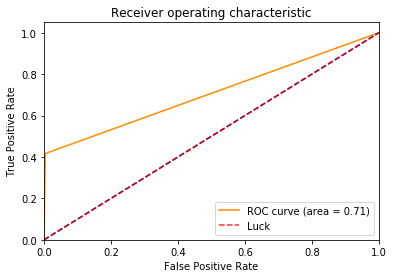

timestamp =  2017-05-11 20:00:04
auc_score =  0.587349980643 	feature importances: [ 0.44  0.22  0.34  0.  ]


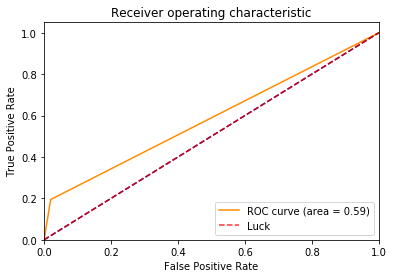

timestamp =  2017-05-11 21:00:04
auc_score =  0.5 	feature importances: [ 0.48  0.26  0.26  0.  ]
timestamp =  2017-05-11 22:00:04
auc_score =  0.497096399535 	feature importances: [ 0.42  0.36  0.22  0.  ]
timestamp =  2017-05-11 23:00:04
auc_score =  0.51214672861 	feature importances: [ 0.52  0.24  0.24  0.  ]
timestamp =  2017-05-12 00:00:04
auc_score =  0.499419953596 	feature importances: [ 0.38  0.28  0.34  0.  ]
timestamp =  2017-05-12 01:00:04
auc_score =  0.515548312165 	feature importances: [ 0.32  0.34  0.34  0.  ]
timestamp =  2017-05-14 03:00:04
auc_score =  0.680555555556 	feature importances: [ 0.2   0.52  0.28  0.  ]


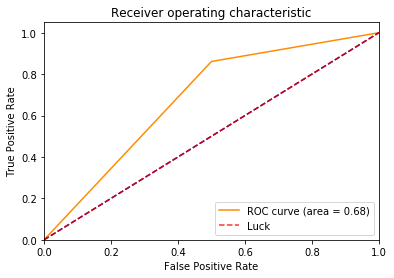

timestamp =  2017-05-14 04:00:04
auc_score =  0.838675213675 	feature importances: [ 0.32  0.44  0.24  0.  ]


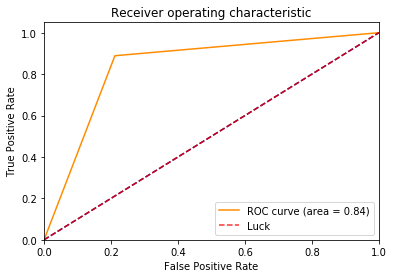

timestamp =  2017-05-14 05:00:04
auc_score =  0.868686868687 	feature importances: [ 0.32  0.46  0.22  0.  ]


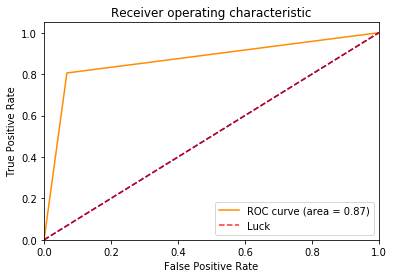

timestamp =  2017-05-14 06:00:04
auc_score =  0.650283347864 	feature importances: [ 0.32  0.22  0.46  0.  ]


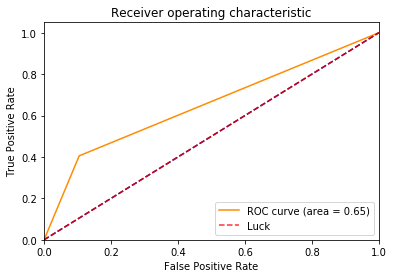

timestamp =  2017-05-14 07:00:04
auc_score =  0.51682194617 	feature importances: [ 0.36  0.4   0.24  0.  ]
timestamp =  2017-05-14 08:00:04
auc_score =  0.629935138184 	feature importances: [ 0.34  0.3   0.36  0.  ]


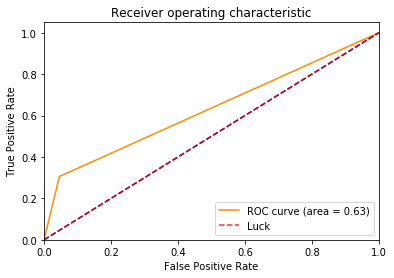

timestamp =  2017-05-14 09:00:04
auc_score =  0.61087164751 	feature importances: [ 0.3   0.42  0.28  0.  ]


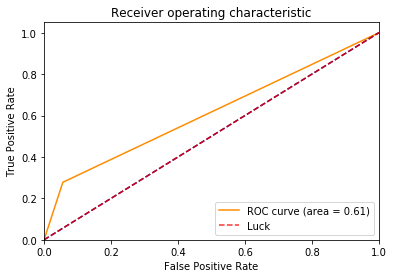

timestamp =  2017-05-14 10:00:04
auc_score =  0.825870646766 	feature importances: [ 0.4   0.26  0.34  0.  ]


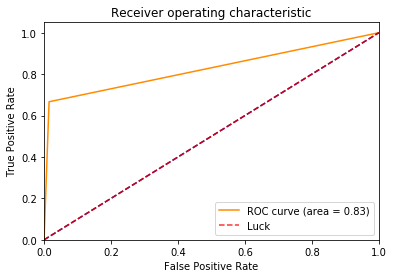

timestamp =  2017-05-14 11:00:04
auc_score =  0.647843567251 	feature importances: [ 0.34  0.4   0.26  0.  ]


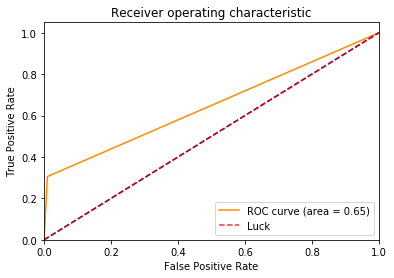

timestamp =  2017-05-14 12:00:04
auc_score =  0.524836601307 	feature importances: [ 0.48  0.26  0.26  0.  ]
timestamp =  2017-05-14 13:00:04
auc_score =  0.930555555556 	feature importances: [ 0.28  0.32  0.4   0.  ]


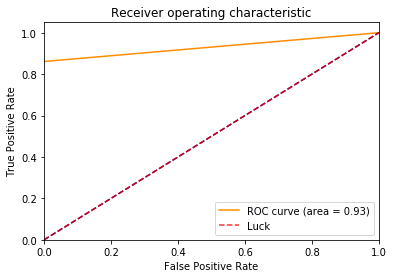

timestamp =  2017-05-14 14:00:04
auc_score =  0.511461704423 	feature importances: [ 0.38  0.38  0.24  0.  ]
timestamp =  2017-05-14 15:00:04
auc_score =  0.627728174603 	feature importances: [ 0.5   0.24  0.26  0.  ]


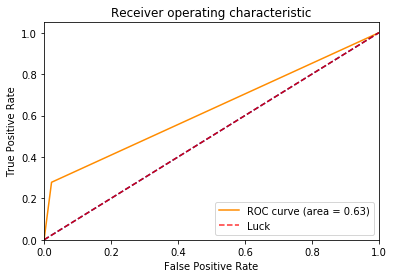

timestamp =  2017-05-14 16:00:04
auc_score =  0.494834710744 	feature importances: [ 0.36  0.34  0.3   0.  ]
timestamp =  2017-05-14 17:00:04
auc_score =  0.631196581197 	feature importances: [ 0.3   0.32  0.38  0.  ]


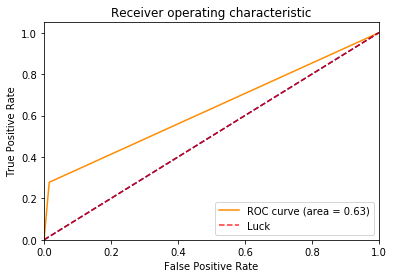

timestamp =  2017-05-14 18:00:04
auc_score =  0.510291766587 	feature importances: [ 0.34  0.46  0.2   0.  ]
timestamp =  2017-05-14 19:00:04
auc_score =  0.497461928934 	feature importances: [ 0.34  0.34  0.32  0.  ]
timestamp =  2017-05-14 20:00:04
auc_score =  0.5 	feature importances: [ 0.36  0.38  0.26  0.  ]
timestamp =  2017-05-14 21:00:04
auc_score =  0.499245852187 	feature importances: [ 0.32  0.6   0.08  0.  ]
timestamp =  2017-05-14 22:00:04
auc_score =  0.655221745351 	feature importances: [ 0.54  0.3   0.16  0.  ]


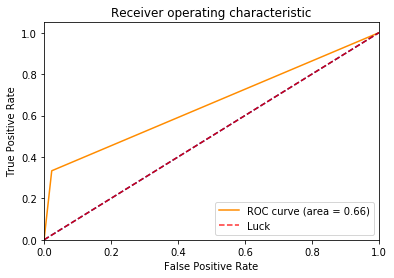

timestamp =  2017-05-14 23:00:04
auc_score =  0.498639455782 	feature importances: [ 0.5   0.18  0.32  0.  ]
timestamp =  2017-05-15 00:00:04
auc_score =  0.5 	feature importances: [ 0.4   0.26  0.34  0.  ]
timestamp =  2017-05-15 01:00:04
auc_score =  0.499379652605 	feature importances: [ 0.38  0.28  0.34  0.  ]
timestamp =  2017-05-15 02:00:04
auc_score =  0.513513513514 	feature importances: [ 0.38  0.34  0.28  0.  ]
timestamp =  2017-05-15 03:00:04
auc_score =  0.5 	feature importances: [ 0.5   0.22  0.28  0.  ]
timestamp =  2017-05-15 04:00:04
auc_score =  0.498841251448 	feature importances: [ 0.34  0.42  0.24  0.  ]
timestamp =  2017-05-15 05:00:04
auc_score =  0.513888888889 	feature importances: [ 0.44  0.3   0.26  0.  ]
timestamp =  2017-05-15 06:00:04
auc_score =  0.5 	feature importances: [ 0.32  0.26  0.42  0.  ]
timestamp =  2017-05-15 07:00:04
auc_score =  0.498259860789 	feature importances: [ 0.42  0.34  0.24  0.  ]
timestamp =  2017-05-15 08:00:04
auc_score =  0.5677

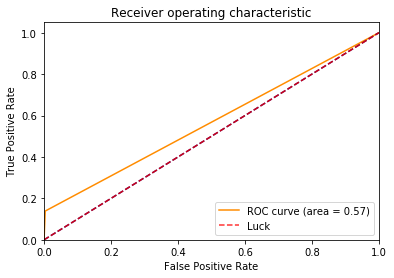

timestamp =  2017-05-15 09:00:04
auc_score =  0.499420625724 	feature importances: [ 0.28  0.38  0.34  0.  ]
timestamp =  2017-05-15 10:00:04
auc_score =  0.60299987125 	feature importances: [ 0.4   0.38  0.22  0.  ]


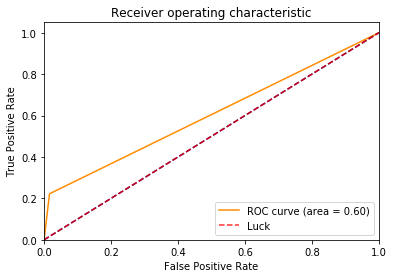

timestamp =  2017-05-15 11:00:04
auc_score =  0.596642847946 	feature importances: [ 0.42  0.24  0.34  0.  ]


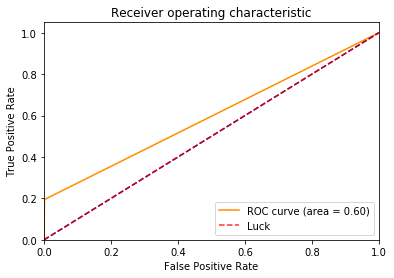

timestamp =  2017-05-15 12:00:04
auc_score =  0.513888888889 	feature importances: [ 0.4   0.24  0.34  0.02]
timestamp =  2017-05-15 13:00:04
auc_score =  0.497679814385 	feature importances: [ 0.48  0.22  0.3   0.  ]
timestamp =  2017-05-15 14:00:04
auc_score =  0.5468548595 	feature importances: [ 0.3   0.48  0.22  0.  ]
timestamp =  2017-05-15 15:00:04
auc_score =  0.5781129157 	feature importances: [ 0.3   0.3   0.38  0.02]


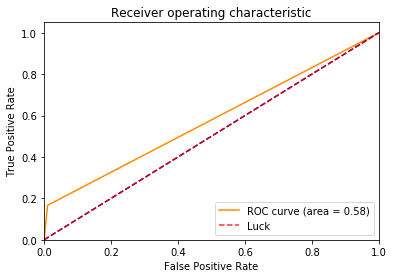

timestamp =  2017-05-15 16:00:04
auc_score =  0.5624838876 	feature importances: [ 0.24  0.46  0.3   0.  ]


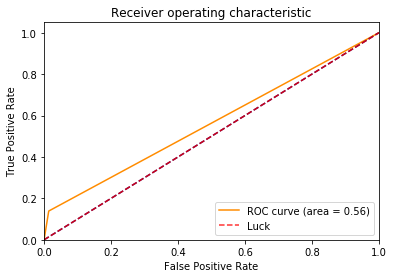

timestamp =  2017-05-15 17:00:04
auc_score =  0.5 	feature importances: [ 0.3   0.44  0.26  0.  ]
timestamp =  2017-05-15 18:00:04
auc_score =  0.496519721578 	feature importances: [ 0.3   0.36  0.32  0.02]
timestamp =  2017-05-15 19:00:04
auc_score =  0.497682502897 	feature importances: [ 0.26  0.36  0.38  0.  ]
timestamp =  2017-05-15 20:00:04
auc_score =  0.5 	feature importances: [ 0.38  0.4   0.22  0.  ]
timestamp =  2017-05-15 21:00:04
auc_score =  0.497682502897 	feature importances: [ 0.3   0.3   0.38  0.02]
timestamp =  2017-05-15 22:00:04
auc_score =  0.620365005794 	feature importances: [ 0.36  0.48  0.16  0.  ]


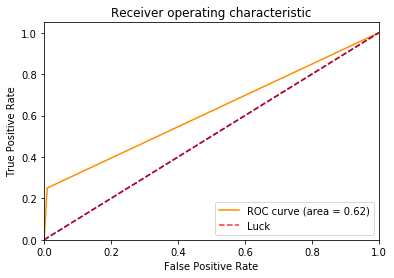

timestamp =  2017-05-15 23:00:04
auc_score =  0.554245985764 	feature importances: [ 0.38  0.32  0.3   0.  ]


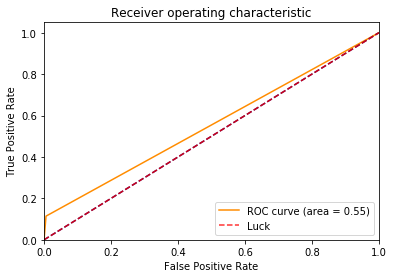

timestamp =  2017-05-16 00:00:04
auc_score =  0.742459396752 	feature importances: [ 0.32  0.36  0.32  0.  ]


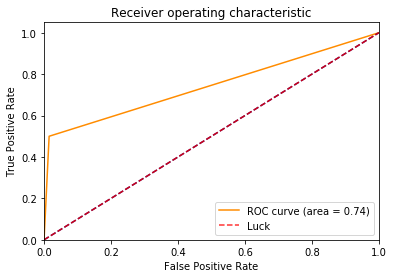

timestamp =  2017-05-16 01:00:04
auc_score =  0.512728796081 	feature importances: [ 0.46  0.3   0.24  0.  ]
timestamp =  2017-05-16 02:00:04
auc_score =  0.5 	feature importances: [ 0.34  0.3   0.36  0.  ]
timestamp =  2017-05-16 03:00:04
auc_score =  0.5 	feature importances: [ 0.36  0.34  0.3   0.  ]
timestamp =  2017-05-16 04:00:04
auc_score =  0.498257839721 	feature importances: [ 0.32  0.38  0.3   0.  ]
timestamp =  2017-05-16 05:00:04
auc_score =  0.647551296942 	feature importances: [ 0.36  0.36  0.28  0.  ]


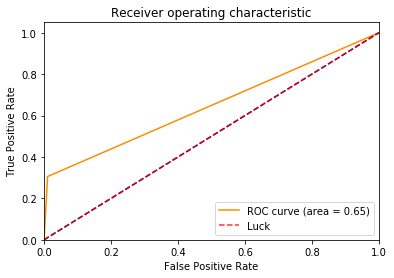

timestamp =  2017-05-16 06:00:04
auc_score =  0.56654084398 	feature importances: [ 0.4   0.32  0.26  0.02]


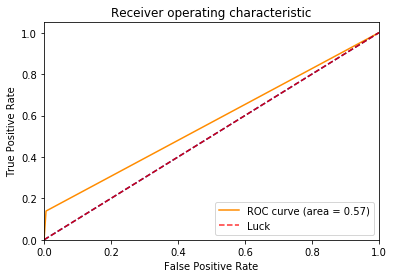

timestamp =  2017-05-16 07:00:04
auc_score =  0.509823848238 	feature importances: [ 0.4   0.46  0.14  0.  ]
timestamp =  2017-05-16 08:00:04
auc_score =  0.513308168796 	feature importances: [ 0.32  0.42  0.26  0.  ]
timestamp =  2017-05-16 09:00:04
auc_score =  0.526035617499 	feature importances: [ 0.42  0.26  0.32  0.  ]
timestamp =  2017-05-16 10:00:04
auc_score =  0.526616337592 	feature importances: [ 0.58  0.24  0.18  0.  ]
timestamp =  2017-05-16 11:00:04
auc_score =  0.527197057685 	feature importances: [ 0.34  0.48  0.18  0.  ]
timestamp =  2017-05-16 12:00:04
auc_score =  0.496515679443 	feature importances: [ 0.34  0.34  0.32  0.  ]
timestamp =  2017-05-16 13:00:04
auc_score =  0.498838559814 	feature importances: [ 0.3  0.4  0.3  0. ]
timestamp =  2017-05-16 14:00:04
auc_score =  0.498838559814 	feature importances: [ 0.38  0.24  0.38  0.  ]
timestamp =  2017-05-16 15:00:04
auc_score =  0.541085946574 	feature importances: [ 0.46  0.2   0.34  0.  ]
timestamp =  2017-05-16

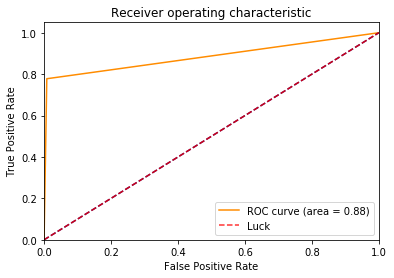

timestamp =  2017-05-16 20:00:04
auc_score =  0.5 	feature importances: [ 0.3   0.3   0.38  0.02]
timestamp =  2017-05-16 21:00:04
auc_score =  0.986111111111 	feature importances: [ 0.14  0.46  0.4   0.  ]


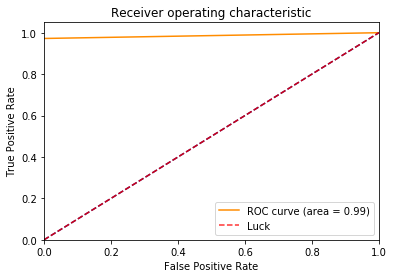

timestamp =  2017-05-16 22:00:04
auc_score =  0.836757105943 	feature importances: [ 0.36  0.34  0.3   0.  ]


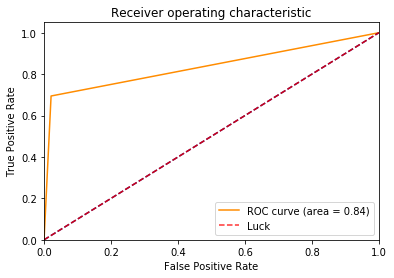

timestamp =  2017-05-16 23:00:04
auc_score =  0.498255813953 	feature importances: [ 0.38  0.34  0.28  0.  ]
timestamp =  2017-05-17 00:00:04
auc_score =  0.554391411202 	feature importances: [ 0.34  0.36  0.3   0.  ]


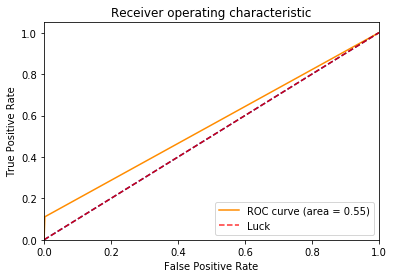

timestamp =  2017-05-17 01:00:04
auc_score =  0.498835855646 	feature importances: [ 0.26  0.4   0.34  0.  ]
timestamp =  2017-05-17 02:00:04
auc_score =  0.512142672358 	feature importances: [ 0.34  0.38  0.28  0.  ]
timestamp =  2017-05-17 03:00:04
auc_score =  0.499417927823 	feature importances: [ 0.46  0.26  0.28  0.  ]
timestamp =  2017-05-17 04:00:04
auc_score =  0.689793281654 	feature importances: [ 0.42  0.32  0.26  0.  ]


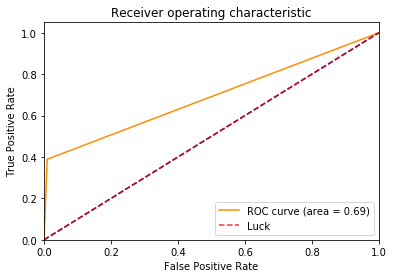

timestamp =  2017-05-17 05:00:04
auc_score =  0.539341085271 	feature importances: [ 0.32  0.4   0.28  0.  ]
timestamp =  2017-05-17 06:00:04
auc_score =  0.5 	feature importances: [ 0.26  0.44  0.3   0.  ]
timestamp =  2017-05-17 07:00:04
auc_score =  0.801485788114 	feature importances: [ 0.26  0.26  0.48  0.  ]


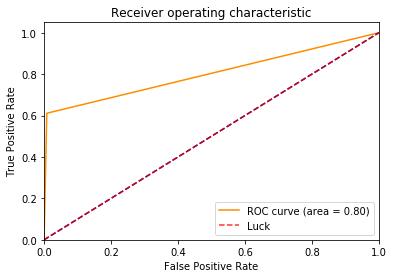

timestamp =  2017-05-17 08:00:04
auc_score =  0.616268917346 	feature importances: [ 0.34  0.36  0.3   0.  ]


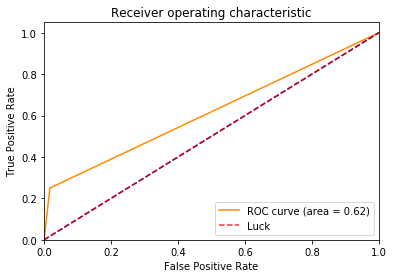

timestamp =  2017-05-17 09:00:04
auc_score =  0.579258828095 	feature importances: [ 0.32  0.3   0.36  0.02]


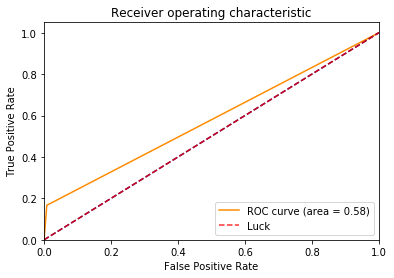

timestamp =  2017-05-17 10:00:04
auc_score =  0.580426356589 	feature importances: [ 0.52  0.24  0.22  0.02]


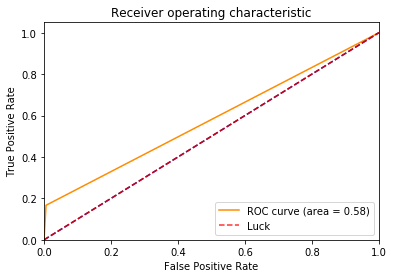

timestamp =  2017-05-17 11:00:04
auc_score =  0.549741602067 	feature importances: [ 0.44  0.24  0.32  0.  ]
timestamp =  2017-05-17 12:00:04
auc_score =  0.692700258398 	feature importances: [ 0.4   0.34  0.26  0.  ]


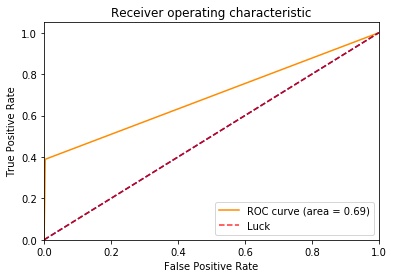

timestamp =  2017-05-17 13:00:04
auc_score =  0.789920450136 	feature importances: [ 0.48  0.3   0.22  0.  ]


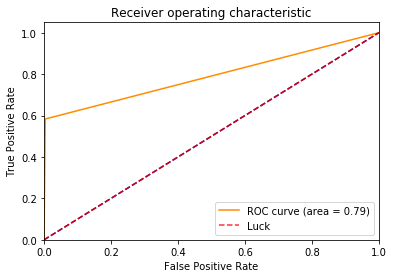

timestamp =  2017-05-17 14:00:04
auc_score =  0.704258828095 	feature importances: [ 0.5   0.22  0.28  0.  ]


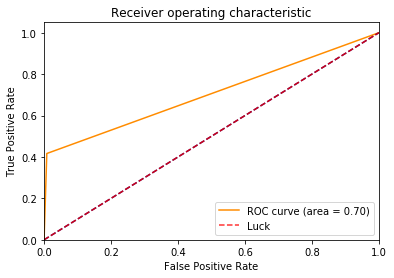

timestamp =  2017-05-17 15:00:04
auc_score =  0.539920450136 	feature importances: [ 0.38  0.34  0.28  0.  ]
timestamp =  2017-05-17 16:00:04
auc_score =  0.51330749354 	feature importances: [ 0.4   0.38  0.22  0.  ]
timestamp =  2017-05-17 17:00:04
auc_score =  0.498837209302 	feature importances: [ 0.34  0.28  0.38  0.  ]
timestamp =  2017-05-17 18:00:04
auc_score =  0.512726098191 	feature importances: [ 0.4   0.36  0.24  0.  ]
timestamp =  2017-05-17 19:00:04
auc_score =  0.55322997416 	feature importances: [ 0.36  0.48  0.16  0.  ]


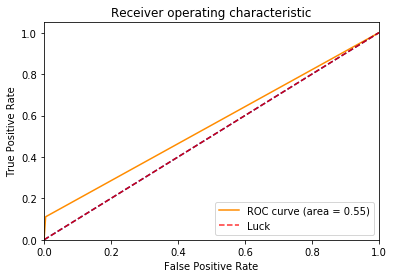

timestamp =  2017-05-17 20:00:04
auc_score =  0.511563307494 	feature importances: [ 0.28  0.36  0.36  0.  ]
timestamp =  2017-05-17 21:00:04
auc_score =  0.496511627907 	feature importances: [ 0.38  0.26  0.36  0.  ]
timestamp =  2017-05-17 22:00:04
auc_score =  0.540503875969 	feature importances: [ 0.3   0.34  0.36  0.  ]
timestamp =  2017-05-17 23:00:04
auc_score =  0.499418604651 	feature importances: [ 0.26  0.4   0.34  0.  ]
timestamp =  2017-05-18 00:00:04
auc_score =  0.5 	feature importances: [ 0.36  0.3   0.34  0.  ]
timestamp =  2017-05-18 01:00:04
auc_score =  0.531644518272 	feature importances: [ 0.34  0.44  0.22  0.  ]
timestamp =  2017-05-18 02:00:04
auc_score =  0.514922870557 	feature importances: [ 0.3   0.44  0.26  0.  ]
timestamp =  2017-05-18 03:00:04
auc_score =  0.49881376038 	feature importances: [ 0.2   0.38  0.42  0.  ]
timestamp =  2017-05-18 04:00:04
auc_score =  0.49940688019 	feature importances: [ 0.28  0.46  0.26  0.  ]
timestamp =  2017-05-18 05:00:04

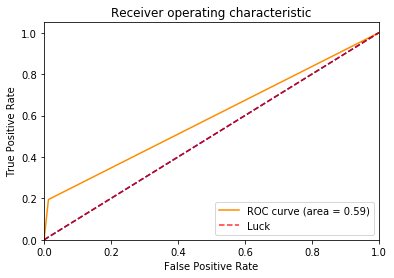

timestamp =  2017-05-18 06:00:04
auc_score =  0.775405298537 	feature importances: [ 0.44  0.26  0.3   0.  ]


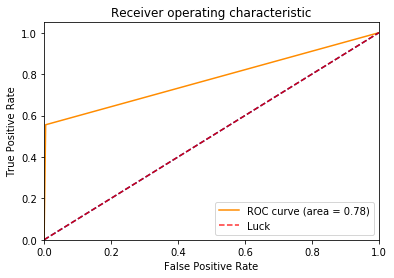

timestamp =  2017-05-18 07:00:04
auc_score =  0.620255041518 	feature importances: [ 0.32  0.38  0.3   0.  ]


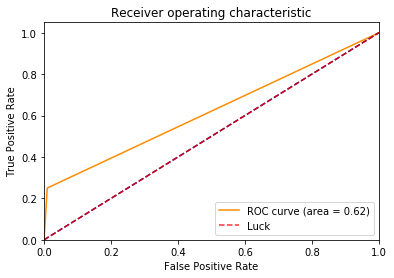

timestamp =  2017-05-18 08:00:04
auc_score =  0.609924871491 	feature importances: [ 0.44  0.2   0.36  0.  ]


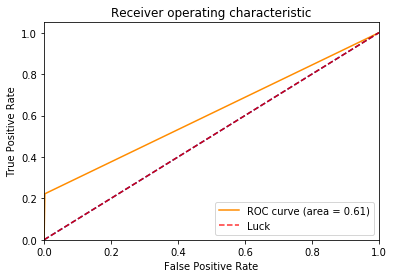

timestamp =  2017-05-18 09:00:04
auc_score =  0.526591538157 	feature importances: [ 0.54  0.3   0.16  0.  ]
timestamp =  2017-05-18 10:00:04
auc_score =  0.523032819296 	feature importances: [ 0.26  0.54  0.2   0.  ]
timestamp =  2017-05-18 11:00:04
auc_score =  0.497627520759 	feature importances: [ 0.4   0.44  0.16  0.  ]
timestamp =  2017-05-18 12:00:04
auc_score =  0.707147093713 	feature importances: [ 0.22  0.34  0.44  0.  ]


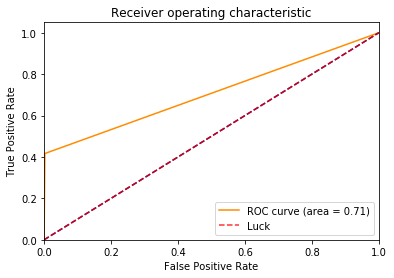

timestamp =  2017-05-18 13:00:04
auc_score =  0.809954527481 	feature importances: [ 0.26  0.46  0.28  0.  ]


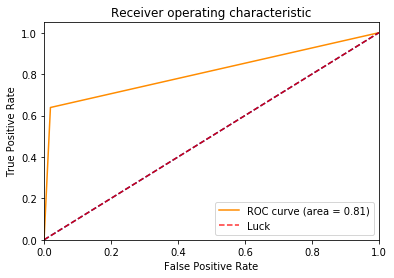

timestamp =  2017-05-18 14:00:04
auc_score =  0.509149552396 	feature importances: [ 0.6   0.2   0.18  0.02]
timestamp =  2017-05-18 15:00:04
auc_score =  0.601621194148 	feature importances: [ 0.4   0.32  0.28  0.  ]


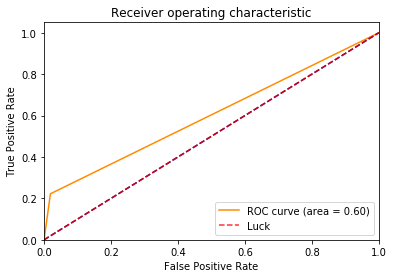

timestamp =  2017-05-18 16:00:04
auc_score =  0.513888888889 	feature importances: [ 0.48  0.3   0.22  0.  ]
timestamp =  2017-05-18 17:00:04
auc_score =  0.49940688019 	feature importances: [ 0.46  0.34  0.2   0.  ]
timestamp =  2017-05-18 18:00:04
auc_score =  0.5 	feature importances: [ 0.44  0.32  0.24  0.  ]
timestamp =  2017-05-18 19:00:04
auc_score =  0.525405298537 	feature importances: [ 0.38  0.22  0.4   0.  ]
timestamp =  2017-05-18 20:00:04
auc_score =  0.512109529458 	feature importances: [ 0.5  0.2  0.3  0. ]
timestamp =  2017-05-18 21:00:04
auc_score =  0.49940688019 	feature importances: [ 0.4  0.2  0.4  0. ]
timestamp =  2017-05-18 22:00:04
auc_score =  0.498220640569 	feature importances: [ 0.36  0.3   0.34  0.  ]
timestamp =  2017-05-18 23:00:04
auc_score =  0.924691228805 	feature importances: [ 0.32  0.44  0.24  0.  ]


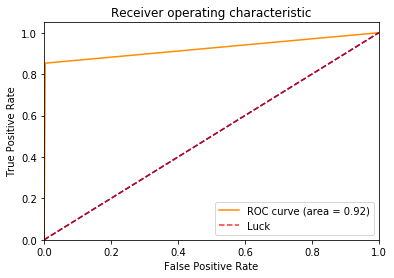

timestamp =  2017-05-19 00:00:04
auc_score =  0.742874109264 	feature importances: [ 0.4   0.32  0.28  0.  ]


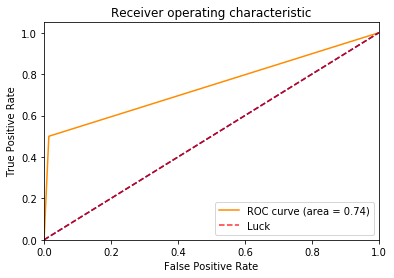

timestamp =  2017-05-19 01:00:04
auc_score =  0.551992610187 	feature importances: [ 0.28  0.24  0.44  0.04]


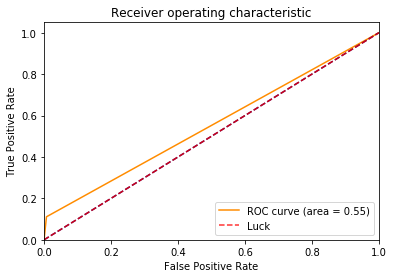

timestamp =  2017-05-19 02:00:04
auc_score =  0.512521008403 	feature importances: [ 0.36  0.4   0.24  0.  ]
timestamp =  2017-05-19 03:00:04
auc_score =  0.544303082772 	feature importances: [ 0.42  0.32  0.26  0.  ]
timestamp =  2017-05-19 04:00:04
auc_score =  0.608173390782 	feature importances: [ 0.7   0.14  0.16  0.  ]


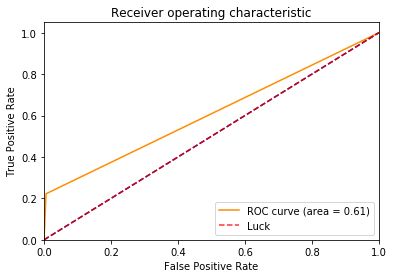

timestamp =  2017-05-19 05:00:04
auc_score =  0.495887191539 	feature importances: [ 0.34  0.44  0.22  0.  ]
timestamp =  2017-05-19 06:00:04
auc_score =  0.49941314554 	feature importances: [ 0.4   0.36  0.24  0.  ]
timestamp =  2017-05-19 07:00:04
auc_score =  0.5 	feature importances: [ 0.34  0.32  0.34  0.  ]
timestamp =  2017-05-19 08:00:04
auc_score =  0.496474735605 	feature importances: [ 0.36  0.48  0.16  0.  ]
timestamp =  2017-05-19 09:00:04
auc_score =  0.498824911868 	feature importances: [ 0.28  0.4   0.32  0.  ]
timestamp =  2017-05-19 10:00:04
auc_score =  0.634188536362 	feature importances: [ 0.34  0.46  0.2   0.  ]


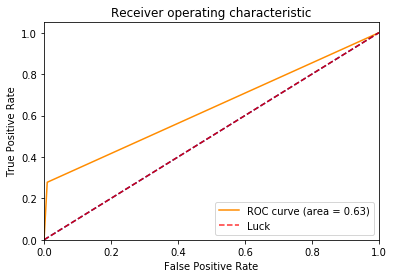

timestamp =  2017-05-19 11:00:04
auc_score =  0.499412455934 	feature importances: [ 0.4  0.4  0.2  0. ]
timestamp =  2017-05-19 12:00:04
auc_score =  0.539316490403 	feature importances: [ 0.26  0.4   0.34  0.  ]
timestamp =  2017-05-19 13:00:04
auc_score =  0.511538712626 	feature importances: [ 0.36  0.34  0.3   0.  ]
timestamp =  2017-05-19 14:00:04
auc_score =  0.563569003786 	feature importances: [ 0.34  0.48  0.18  0.  ]


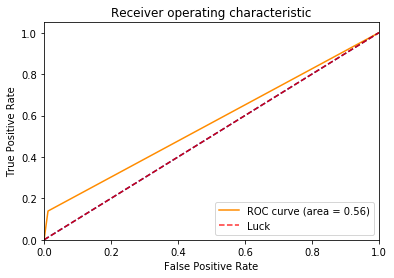

timestamp =  2017-05-19 15:00:04
auc_score =  0.594284501893 	feature importances: [ 0.38  0.5   0.12  0.  ]


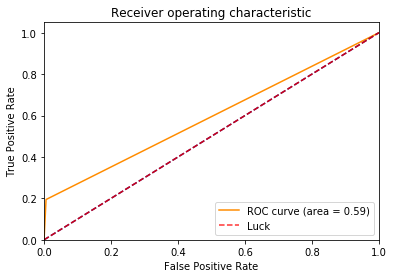

timestamp =  2017-05-19 16:00:04
auc_score =  0.58098315707 	feature importances: [ 0.38  0.4   0.22  0.  ]


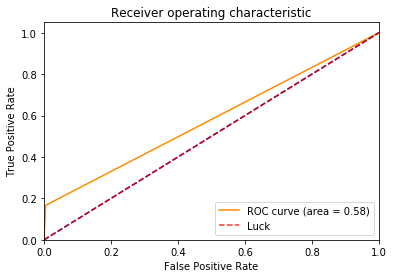

timestamp =  2017-05-19 17:00:04
auc_score =  0.759776080428 	feature importances: [ 0.44  0.36  0.2   0.  ]


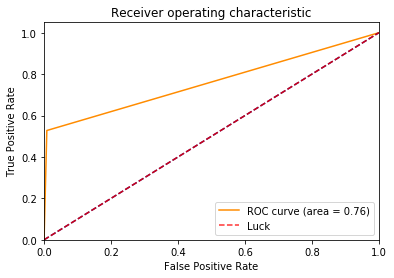

timestamp =  2017-05-19 18:00:04
auc_score =  0.5 	feature importances: [ 0.5   0.28  0.22  0.  ]
timestamp =  2017-05-19 19:00:04
auc_score =  0.552621283255 	feature importances: [ 0.3   0.38  0.32  0.  ]


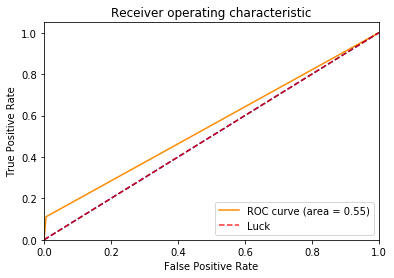

timestamp =  2017-05-19 20:00:04
auc_score =  0.513888888889 	feature importances: [ 0.46  0.28  0.26  0.  ]
timestamp =  2017-05-19 21:00:04
auc_score =  0.550273865415 	feature importances: [ 0.42  0.22  0.36  0.  ]


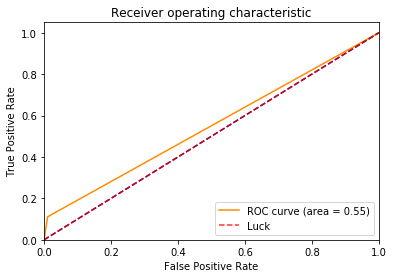

timestamp =  2017-05-19 22:00:04
auc_score =  0.510367762128 	feature importances: [ 0.38  0.4   0.22  0.  ]
timestamp =  2017-05-19 23:00:04
auc_score =  0.49941314554 	feature importances: [ 0.42  0.4   0.18  0.  ]
timestamp =  2017-05-20 00:00:04
auc_score =  0.525433111893 	feature importances: [ 0.3  0.4  0.3  0. ]
timestamp =  2017-05-20 01:00:04
auc_score =  0.581611120415 	feature importances: [ 0.32  0.4   0.28  0.  ]


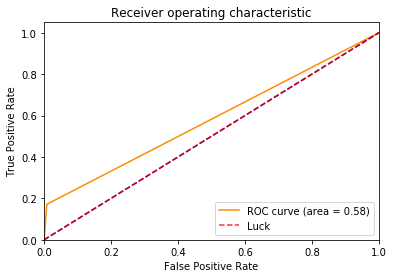

timestamp =  2017-05-20 02:00:04
auc_score =  0.49765258216 	feature importances: [ 0.32  0.32  0.36  0.  ]
timestamp =  2017-05-20 03:00:04
auc_score =  0.512715179969 	feature importances: [ 0.38  0.24  0.38  0.  ]
timestamp =  2017-05-20 04:00:04
auc_score =  0.494165694282 	feature importances: [ 0.3   0.34  0.36  0.  ]
timestamp =  2017-05-20 05:00:04
auc_score =  0.493582263711 	feature importances: [ 0.36  0.28  0.36  0.  ]
timestamp =  2017-05-20 06:00:04
auc_score =  0.5 	feature importances: [ 0.4   0.38  0.22  0.  ]
timestamp =  2017-05-20 07:00:04
auc_score =  0.513306138306 	feature importances: [ 0.52  0.22  0.24  0.02]
timestamp =  2017-05-20 08:00:04
auc_score =  0.497082847141 	feature importances: [ 0.34  0.3   0.36  0.  ]
timestamp =  2017-05-20 09:00:04
auc_score =  0.5 	feature importances: [ 0.26  0.38  0.36  0.  ]
timestamp =  2017-05-20 10:00:04
auc_score =  0.498834498834 	feature importances: [ 0.32  0.38  0.3   0.  ]
timestamp =  2017-05-20 11:00:04
auc_score

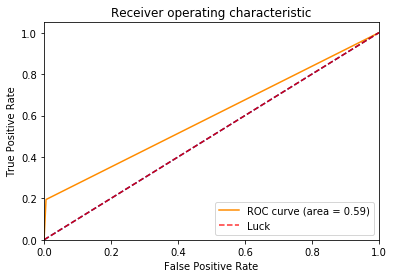

timestamp =  2017-05-20 12:00:04
auc_score =  0.499417249417 	feature importances: [ 0.46  0.34  0.2   0.  ]
timestamp =  2017-05-20 13:00:04
auc_score =  0.52602952603 	feature importances: [ 0.36  0.24  0.4   0.  ]
timestamp =  2017-05-20 14:00:04
auc_score =  0.510975135975 	feature importances: [ 0.34  0.18  0.48  0.  ]
timestamp =  2017-05-20 15:00:04
auc_score =  0.524864024864 	feature importances: [ 0.46  0.34  0.2   0.  ]
timestamp =  2017-05-20 16:00:04
auc_score =  0.511557886558 	feature importances: [ 0.12  0.5   0.38  0.  ]
timestamp =  2017-05-20 17:00:04
auc_score =  0.513888888889 	feature importances: [ 0.66  0.22  0.12  0.  ]
timestamp =  2017-05-20 18:00:04
auc_score =  0.498834498834 	feature importances: [ 0.42  0.38  0.2   0.  ]
timestamp =  2017-05-20 19:00:04
auc_score =  0.527195027195 	feature importances: [ 0.4   0.36  0.24  0.  ]
timestamp =  2017-05-20 20:00:04
auc_score =  0.497668997669 	feature importances: [ 0.18  0.46  0.36  0.  ]
timestamp =  2017-05

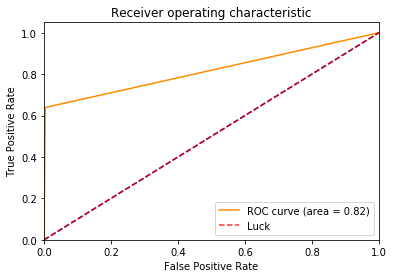

timestamp =  2017-05-20 23:00:04
auc_score =  0.983383283383 	feature importances: [ 0.36  0.36  0.28  0.  ]


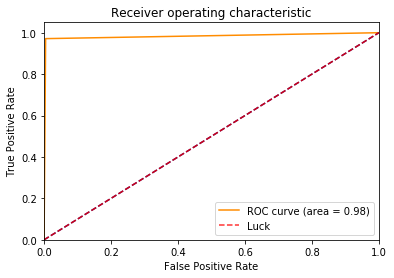

timestamp =  2017-05-21 00:00:04
auc_score =  0.895776610917 	feature importances: [ 0.2   0.36  0.44  0.  ]


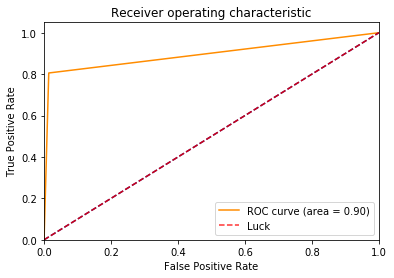

timestamp =  2017-05-21 01:00:04
auc_score =  0.815360430442 	feature importances: [ 0.36  0.14  0.44  0.06]


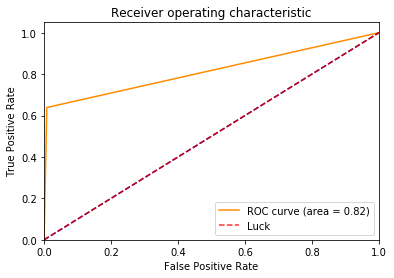

timestamp =  2017-05-21 02:00:04
auc_score =  0.911421911422 	feature importances: [ 0.54  0.28  0.18  0.  ]


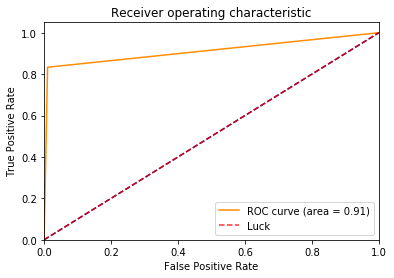

timestamp =  2017-05-21 03:00:04
auc_score =  0.539341085271 	feature importances: [ 0.46  0.32  0.22  0.  ]
timestamp =  2017-05-21 04:00:04
auc_score =  0.51330749354 	feature importances: [ 0.26  0.3   0.44  0.  ]
timestamp =  2017-05-21 05:00:04
auc_score =  0.495348837209 	feature importances: [ 0.34  0.38  0.28  0.  ]
timestamp =  2017-05-21 06:00:04
auc_score =  0.499417927823 	feature importances: [ 0.56  0.08  0.34  0.02]
timestamp =  2017-05-21 07:00:04
auc_score =  0.5 	feature importances: [ 0.38  0.36  0.26  0.  ]
timestamp =  2017-05-21 08:00:04
auc_score =  0.497089639115 	feature importances: [ 0.42  0.3   0.28  0.  ]
timestamp =  2017-05-21 09:00:04
auc_score =  0.512724744535 	feature importances: [ 0.28  0.44  0.28  0.  ]
timestamp =  2017-05-21 10:00:04
auc_score =  0.498835855646 	feature importances: [ 0.24  0.32  0.44  0.  ]
timestamp =  2017-05-21 11:00:04
auc_score =  0.512724744535 	feature importances: [ 0.42  0.3   0.28  0.  ]
timestamp =  2017-05-21 12:00:0

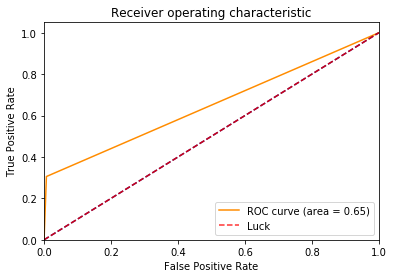

timestamp =  2017-05-21 18:00:04
auc_score =  0.5 	feature importances: [ 0.46  0.4   0.14  0.  ]
timestamp =  2017-05-21 19:00:04
auc_score =  0.498835855646 	feature importances: [ 0.3   0.34  0.36  0.  ]
timestamp =  2017-05-21 20:00:04
auc_score =  0.497671711292 	feature importances: [ 0.36  0.36  0.28  0.  ]
timestamp =  2017-05-21 21:00:04
auc_score =  0.539335664336 	feature importances: [ 0.42  0.38  0.2   0.  ]
timestamp =  2017-05-21 22:00:04
auc_score =  0.735528360528 	feature importances: [ 0.28  0.3   0.42  0.  ]


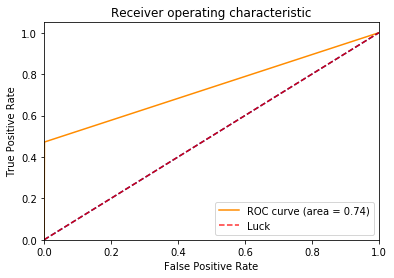

timestamp =  2017-05-21 23:00:04
auc_score =  0.597089639115 	feature importances: [ 0.4   0.36  0.24  0.  ]


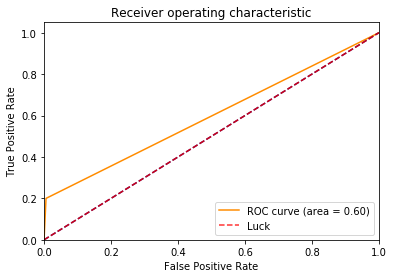

timestamp =  2017-05-22 00:00:04
auc_score =  0.512726098191 	feature importances: [ 0.34  0.34  0.32  0.  ]
timestamp =  2017-05-22 01:00:04
auc_score =  0.608785529716 	feature importances: [ 0.36  0.42  0.22  0.  ]


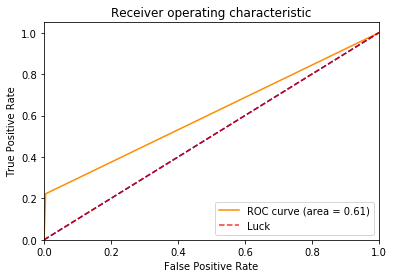

timestamp =  2017-05-22 02:00:04
auc_score =  0.499418604651 	feature importances: [ 0.38  0.32  0.3   0.  ]
timestamp =  2017-05-22 03:00:04
auc_score =  0.498833138856 	feature importances: [ 0.32  0.28  0.4   0.  ]
timestamp =  2017-05-22 04:00:04
auc_score =  0.498833138856 	feature importances: [ 0.38  0.26  0.36  0.  ]
timestamp =  2017-05-22 05:00:04
auc_score =  0.498833138856 	feature importances: [ 0.24  0.38  0.36  0.02]
timestamp =  2017-05-22 06:00:04
auc_score =  0.498834498834 	feature importances: [ 0.44  0.2   0.36  0.  ]
timestamp =  2017-05-22 07:00:04
auc_score =  0.498251748252 	feature importances: [ 0.28  0.32  0.4   0.  ]
timestamp =  2017-05-22 08:00:04
auc_score =  0.512723387723 	feature importances: [ 0.5  0.2  0.3  0. ]
timestamp =  2017-05-22 09:00:04
auc_score =  0.498251748252 	feature importances: [ 0.46  0.26  0.28  0.  ]
timestamp =  2017-05-22 10:00:04
auc_score =  0.605283605284 	feature importances: [ 0.4   0.42  0.18  0.  ]


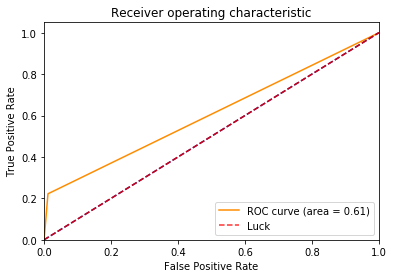

timestamp =  2017-05-22 11:00:04
auc_score =  0.512723387723 	feature importances: [ 0.4   0.34  0.26  0.  ]
timestamp =  2017-05-22 12:00:04
auc_score =  0.498834498834 	feature importances: [ 0.38  0.36  0.26  0.  ]
timestamp =  2017-05-22 13:00:04
auc_score =  0.5 	feature importances: [ 0.48  0.36  0.16  0.  ]
timestamp =  2017-05-22 14:00:04
auc_score =  0.498834498834 	feature importances: [ 0.48  0.24  0.28  0.  ]
timestamp =  2017-05-22 15:00:04
auc_score =  0.510975135975 	feature importances: [ 0.32  0.22  0.46  0.  ]
timestamp =  2017-05-22 16:00:04
auc_score =  0.5 	feature importances: [ 0.16  0.4   0.44  0.  ]
timestamp =  2017-05-22 17:00:04
auc_score =  0.527777777778 	feature importances: [ 0.38  0.38  0.24  0.  ]
timestamp =  2017-05-22 18:00:04
auc_score =  0.499417249417 	feature importances: [ 0.38  0.3   0.32  0.  ]
timestamp =  2017-05-22 19:00:04
auc_score =  0.510388305458 	feature importances: [ 0.5   0.34  0.16  0.  ]
timestamp =  2017-05-22 20:00:04
auc_scor

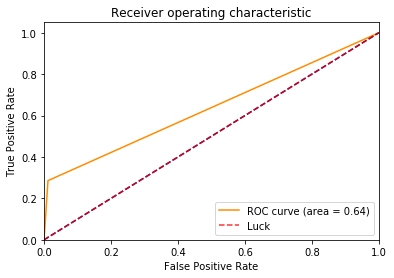

timestamp =  2017-05-23 00:00:04
auc_score =  0.539335664336 	feature importances: [ 0.4   0.28  0.32  0.  ]
timestamp =  2017-05-23 01:00:04
auc_score =  0.568278943279 	feature importances: [ 0.32  0.46  0.22  0.  ]


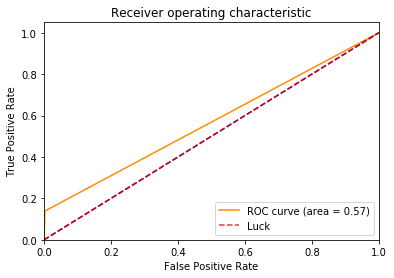

timestamp =  2017-05-23 02:00:04
auc_score =  0.540501165501 	feature importances: [ 0.52  0.22  0.26  0.  ]
timestamp =  2017-05-23 03:00:04
auc_score =  0.538178294574 	feature importances: [ 0.3   0.32  0.38  0.  ]
timestamp =  2017-05-23 04:00:04
auc_score =  0.511563307494 	feature importances: [ 0.36  0.38  0.24  0.02]
timestamp =  2017-05-23 05:00:04
auc_score =  0.513888888889 	feature importances: [ 0.44  0.24  0.3   0.02]
timestamp =  2017-05-23 06:00:04
auc_score =  0.499418604651 	feature importances: [ 0.38  0.22  0.38  0.02]
timestamp =  2017-05-23 07:00:04
auc_score =  0.498257839721 	feature importances: [ 0.44  0.24  0.3   0.02]
timestamp =  2017-05-23 08:00:04
auc_score =  0.608785529716 	feature importances: [ 0.3  0.3  0.4  0. ]


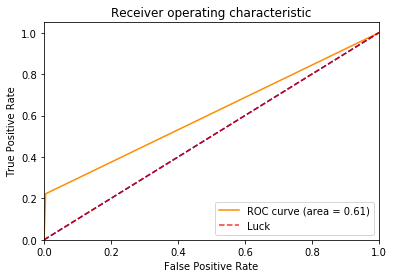

timestamp =  2017-05-23 09:00:04
auc_score =  0.579849012776 	feature importances: [ 0.44  0.26  0.3   0.  ]


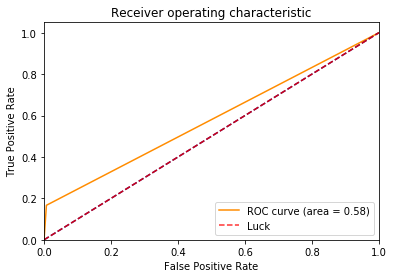

timestamp =  2017-05-23 10:00:04
auc_score =  0.497093023256 	feature importances: [ 0.24  0.36  0.4   0.  ]
timestamp =  2017-05-23 11:00:04
auc_score =  0.499418604651 	feature importances: [ 0.34  0.26  0.4   0.  ]
timestamp =  2017-05-23 12:00:04
auc_score =  0.512144702842 	feature importances: [ 0.38  0.36  0.24  0.02]
timestamp =  2017-05-23 13:00:04
auc_score =  0.499418604651 	feature importances: [ 0.38  0.28  0.34  0.  ]
timestamp =  2017-05-23 14:00:04
auc_score =  0.498837209302 	feature importances: [ 0.42  0.4   0.18  0.  ]
timestamp =  2017-05-23 15:00:04
auc_score =  0.52492715064 	feature importances: [ 0.42  0.3   0.28  0.  ]
timestamp =  2017-05-23 16:00:04
auc_score =  0.499441340782 	feature importances: [ 0.34  0.26  0.4   0.  ]
timestamp =  2017-05-23 17:00:04
auc_score =  0.516875583141 	feature importances: [ 0.34  0.4   0.26  0.  ]
timestamp =  2017-05-23 18:00:04
auc_score =  0.497851772288 	feature importances: [ 0.36  0.3   0.34  0.  ]
timestamp =  2017-05

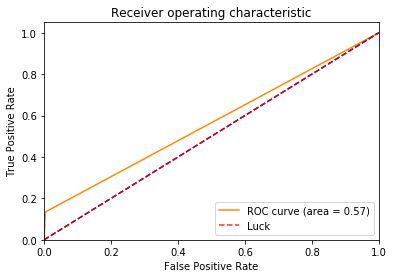

timestamp =  2017-05-24 00:00:04
auc_score =  0.507814172554 	feature importances: [ 0.44  0.28  0.28  0.  ]
timestamp =  2017-05-24 01:00:04
auc_score =  0.508785774411 	feature importances: [ 0.34  0.4   0.26  0.  ]
timestamp =  2017-05-24 02:00:04
auc_score =  0.510645561763 	feature importances: [ 0.26  0.44  0.3   0.  ]
timestamp =  2017-05-24 03:00:04
auc_score =  0.539358264081 	feature importances: [ 0.3   0.26  0.44  0.  ]
timestamp =  2017-05-24 04:00:04
auc_score =  0.498153277932 	feature importances: [ 0.46  0.16  0.38  0.  ]
timestamp =  2017-05-24 05:00:04
auc_score =  0.5 	feature importances: [ 0.3   0.28  0.42  0.  ]
timestamp =  2017-05-24 06:00:04
auc_score =  0.499538319483 	feature importances: [ 0.28  0.48  0.24  0.  ]
timestamp =  2017-05-24 07:00:04
auc_score =  0.499538319483 	feature importances: [ 0.42  0.24  0.34  0.  ]
timestamp =  2017-05-24 08:00:04
auc_score =  0.499076638966 	feature importances: [ 0.22  0.3   0.48  0.  ]
timestamp =  2017-05-24 14:00:

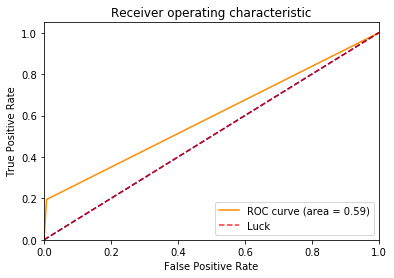

timestamp =  2017-05-25 01:00:04
auc_score =  0.574283559578 	feature importances: [ 0.34  0.28  0.38  0.  ]


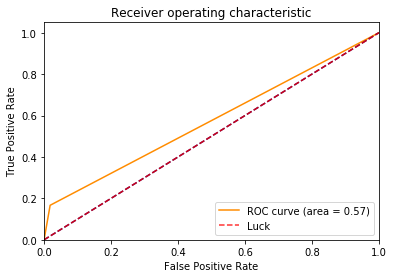

timestamp =  2017-05-25 02:00:04
auc_score =  0.909689922481 	feature importances: [ 0.36  0.32  0.32  0.  ]


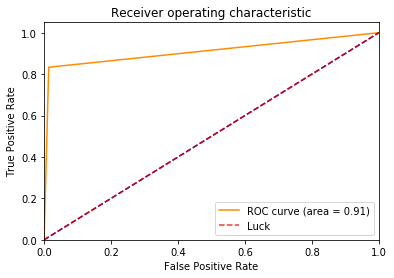

timestamp =  2017-05-25 03:00:04
auc_score =  0.580188679245 	feature importances: [ 0.46  0.24  0.3   0.  ]


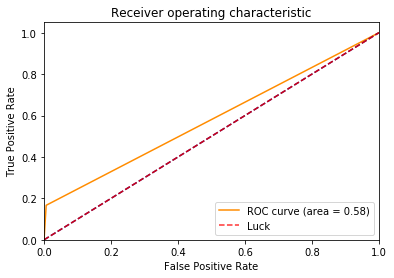

timestamp =  2017-05-25 04:00:04
auc_score =  0.788522012579 	feature importances: [ 0.4   0.22  0.38  0.  ]


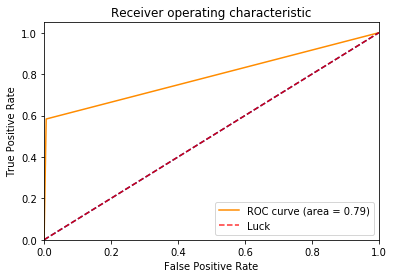

timestamp =  2017-05-25 05:00:04
auc_score =  0.64963312369 	feature importances: [ 0.14  0.44  0.42  0.  ]


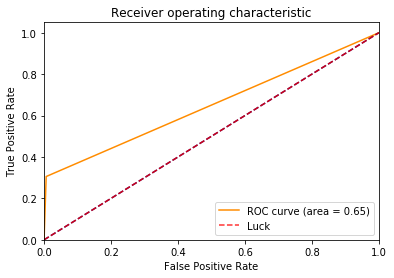

timestamp =  2017-05-25 06:00:04
auc_score =  0.497641509434 	feature importances: [ 0.24  0.38  0.38  0.  ]
timestamp =  2017-05-25 07:00:04
auc_score =  0.74606918239 	feature importances: [ 0.34  0.34  0.32  0.  ]


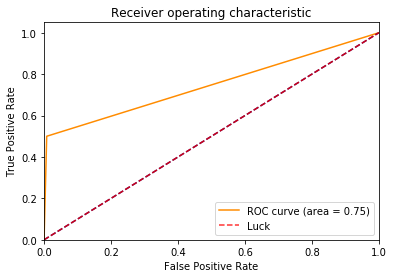

timestamp =  2017-05-25 08:00:04
auc_score =  0.5 	feature importances: [ 0.26  0.36  0.38  0.  ]
timestamp =  2017-05-25 09:00:04
auc_score =  0.5 	feature importances: [ 0.42  0.42  0.16  0.  ]
timestamp =  2017-05-25 10:00:04
auc_score =  0.512835622054 	feature importances: [ 0.4   0.34  0.26  0.  ]
timestamp =  2017-05-25 11:00:04
auc_score =  0.511257606491 	feature importances: [ 0.42  0.28  0.3   0.  ]
timestamp =  2017-05-25 12:00:04
auc_score =  0.498682476943 	feature importances: [ 0.26  0.38  0.36  0.  ]
timestamp =  2017-05-25 13:00:04
auc_score =  0.496855345912 	feature importances: [ 0.36  0.32  0.32  0.  ]
timestamp =  2017-05-25 14:00:04
auc_score =  0.513888888889 	feature importances: [ 0.26  0.42  0.32  0.  ]
timestamp =  2017-05-25 15:00:04
auc_score =  0.496466431095 	feature importances: [ 0.36  0.3   0.32  0.02]
timestamp =  2017-05-25 16:00:04
auc_score =  0.509727176642 	feature importances: [ 0.28  0.36  0.36  0.  ]
timestamp =  2017-05-25 17:00:04
auc_scor

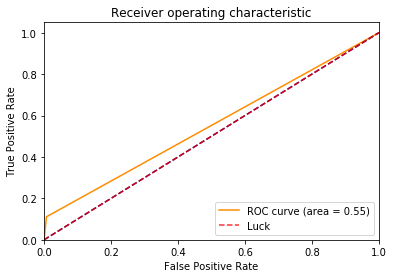

timestamp =  2017-05-26 01:00:04
auc_score =  0.512696993776 	feature importances: [ 0.38  0.4   0.22  0.  ]
timestamp =  2017-05-26 02:00:04
auc_score =  0.499404052443 	feature importances: [ 0.36  0.38  0.26  0.  ]
timestamp =  2017-05-26 03:00:04
auc_score =  0.49821215733 	feature importances: [ 0.38  0.34  0.28  0.  ]
timestamp =  2017-05-26 04:00:04
auc_score =  0.567656601775 	feature importances: [ 0.62  0.18  0.2   0.  ]


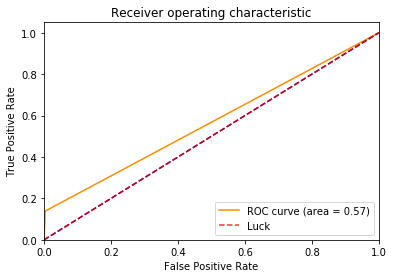

timestamp =  2017-05-26 05:00:04
auc_score =  0.499404052443 	feature importances: [ 0.2   0.56  0.24  0.  ]
timestamp =  2017-05-26 06:00:04
auc_score =  0.5 	feature importances: [ 0.38  0.38  0.24  0.  ]
timestamp =  2017-05-26 07:00:04
auc_score =  0.5 	feature importances: [ 0.2  0.4  0.4  0. ]
timestamp =  2017-05-26 08:00:04
auc_score =  0.58887895643 	feature importances: [ 0.26  0.38  0.36  0.  ]


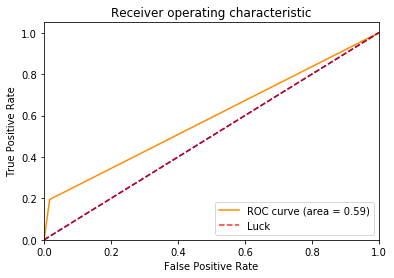

timestamp =  2017-05-26 09:00:04
auc_score =  0.550787975103 	feature importances: [ 0.36  0.22  0.42  0.  ]


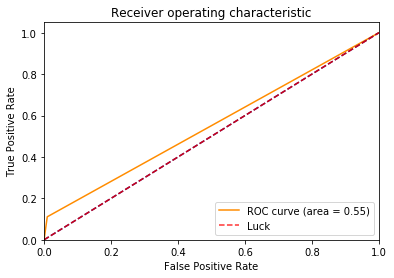

timestamp =  2017-05-26 10:00:04
auc_score =  0.660707191101 	feature importances: [ 0.38  0.28  0.34  0.  ]


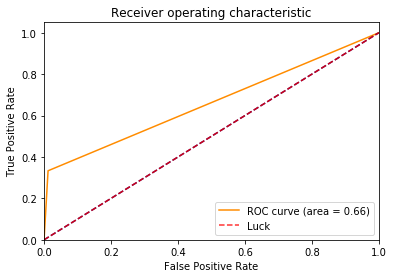

timestamp =  2017-05-26 11:00:04
auc_score =  0.523645546373 	feature importances: [ 0.38  0.28  0.32  0.02]
timestamp =  2017-05-26 12:00:04
auc_score =  0.5 	feature importances: [ 0.3   0.24  0.46  0.  ]
timestamp =  2017-05-26 13:00:04
auc_score =  0.513888888889 	feature importances: [ 0.26  0.46  0.28  0.  ]
timestamp =  2017-05-26 14:00:04
auc_score =  0.499411071849 	feature importances: [ 0.5   0.26  0.24  0.  ]
timestamp =  2017-05-26 15:00:04
auc_score =  0.527188849627 	feature importances: [ 0.38  0.26  0.32  0.04]
timestamp =  2017-05-26 16:00:04
auc_score =  0.498834498834 	feature importances: [ 0.34  0.26  0.4   0.  ]
timestamp =  2017-05-26 17:00:04
auc_score =  0.5 	feature importances: [ 0.38  0.3   0.32  0.  ]
timestamp =  2017-05-26 18:00:04
auc_score =  0.498838559814 	feature importances: [ 0.24  0.42  0.34  0.  ]
timestamp =  2017-05-26 19:00:04
auc_score =  0.496515679443 	feature importances: [ 0.28  0.4   0.32  0.  ]
timestamp =  2017-05-26 20:00:04
auc_scor

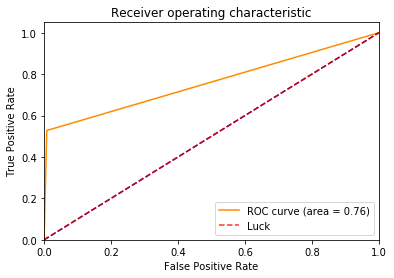

timestamp =  2017-05-26 23:00:04
auc_score =  0.499419279907 	feature importances: [ 0.32  0.46  0.22  0.  ]
timestamp =  2017-05-27 00:00:04
auc_score =  0.498838559814 	feature importances: [ 0.3   0.32  0.38  0.  ]
timestamp =  2017-05-27 01:00:04
auc_score =  0.498838559814 	feature importances: [ 0.5   0.26  0.24  0.  ]
timestamp =  2017-05-27 02:00:04
auc_score =  0.52429345722 	feature importances: [ 0.18  0.38  0.44  0.  ]
timestamp =  2017-05-27 03:00:04
auc_score =  0.527197057685 	feature importances: [ 0.52  0.3   0.18  0.  ]
timestamp =  2017-05-27 04:00:04
auc_score =  0.57868757259 	feature importances: [ 0.32  0.34  0.34  0.  ]


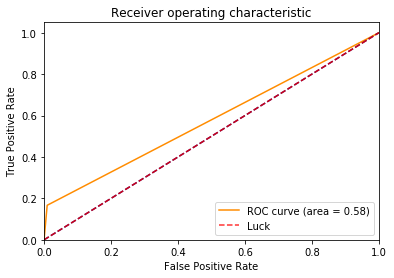

timestamp =  2017-05-27 05:00:04
auc_score =  0.692702284166 	feature importances: [ 0.44  0.28  0.28  0.  ]


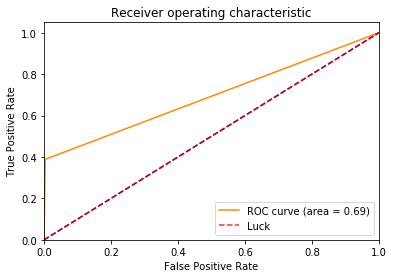

timestamp =  2017-05-27 06:00:04
auc_score =  0.756339527681 	feature importances: [ 0.38  0.26  0.36  0.  ]


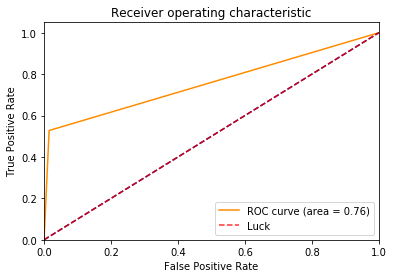

timestamp =  2017-05-27 07:00:04
auc_score =  0.540505226481 	feature importances: [ 0.42  0.24  0.34  0.  ]
timestamp =  2017-05-27 08:00:04
auc_score =  0.70368757259 	feature importances: [ 0.48  0.28  0.24  0.  ]


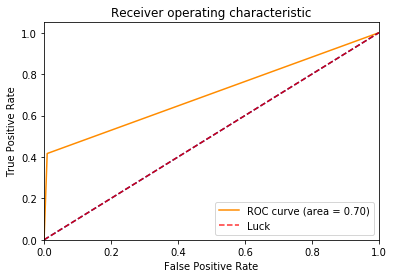

timestamp =  2017-05-27 09:00:04
auc_score =  0.592576461479 	feature importances: [ 0.26  0.38  0.36  0.  ]


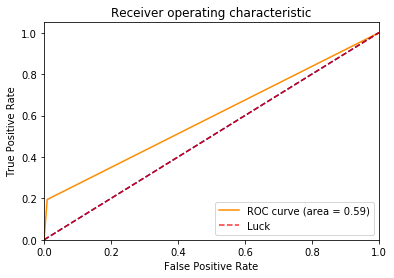

timestamp =  2017-05-27 10:00:04
auc_score =  0.51214672861 	feature importances: [ 0.54  0.2   0.26  0.  ]
timestamp =  2017-05-27 11:00:04
auc_score =  0.49593495935 	feature importances: [ 0.28  0.42  0.3   0.  ]
timestamp =  2017-05-27 12:00:04
auc_score =  0.513308168796 	feature importances: [ 0.38  0.36  0.26  0.  ]
timestamp =  2017-05-27 13:00:04
auc_score =  0.499419279907 	feature importances: [ 0.26  0.42  0.32  0.  ]
timestamp =  2017-05-27 14:00:04
auc_score =  0.499419279907 	feature importances: [ 0.38  0.32  0.28  0.02]
timestamp =  2017-05-27 15:00:04
auc_score =  0.509243128146 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-27 16:00:04
auc_score =  0.630758807588 	feature importances: [ 0.2   0.44  0.36  0.  ]


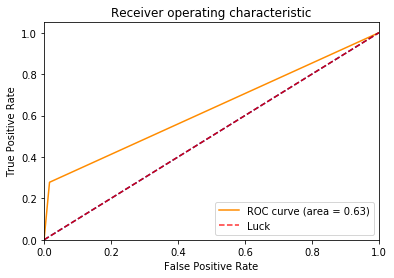

timestamp =  2017-05-27 17:00:04
auc_score =  0.720480061943 	feature importances: [ 0.44  0.28  0.28  0.  ]


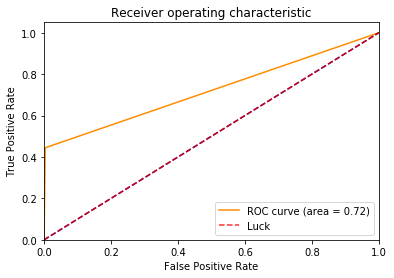

timestamp =  2017-05-27 18:00:04
auc_score =  0.513888888889 	feature importances: [ 0.34  0.36  0.3   0.  ]
timestamp =  2017-05-27 19:00:04
auc_score =  0.51214672861 	feature importances: [ 0.28  0.44  0.28  0.  ]
timestamp =  2017-05-27 20:00:04
auc_score =  0.498838559814 	feature importances: [ 0.34  0.38  0.28  0.  ]
timestamp =  2017-05-27 21:00:04
auc_score =  0.513308168796 	feature importances: [ 0.48  0.34  0.18  0.  ]
timestamp =  2017-05-27 22:00:04
auc_score =  0.498838559814 	feature importances: [ 0.26  0.52  0.22  0.  ]
timestamp =  2017-05-27 23:00:04
auc_score =  0.5 	feature importances: [ 0.26  0.38  0.36  0.  ]
timestamp =  2017-05-28 00:00:04
auc_score =  0.774870801034 	feature importances: [ 0.22  0.32  0.44  0.02]


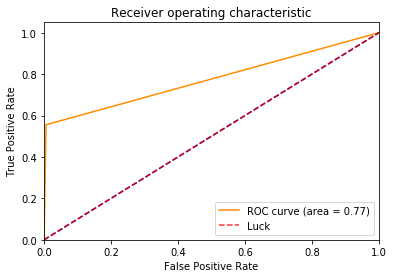

timestamp =  2017-05-28 01:00:04
auc_score =  0.738966318235 	feature importances: [ 0.26  0.38  0.34  0.02]


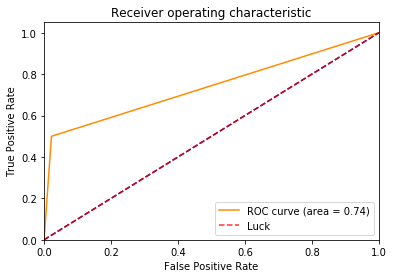

timestamp =  2017-05-28 02:00:04
auc_score =  0.773712737127 	feature importances: [ 0.44  0.26  0.3   0.  ]


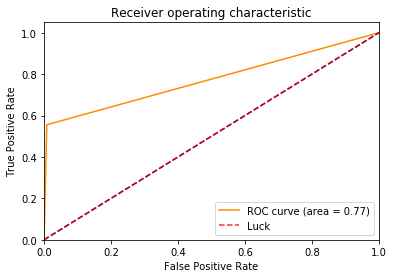

timestamp =  2017-05-28 03:00:04
auc_score =  0.52429345722 	feature importances: [ 0.36  0.3   0.34  0.  ]
timestamp =  2017-05-28 04:00:04
auc_score =  0.541666666667 	feature importances: [ 0.24  0.4   0.36  0.  ]
timestamp =  2017-05-28 05:00:04
auc_score =  0.5 	feature importances: [ 0.32  0.34  0.34  0.  ]
timestamp =  2017-05-28 06:00:04
auc_score =  0.499419279907 	feature importances: [ 0.26  0.3   0.44  0.  ]
timestamp =  2017-05-28 07:00:04
auc_score =  0.52661498708 	feature importances: [ 0.48  0.36  0.16  0.  ]
timestamp =  2017-05-28 08:00:04
auc_score =  0.498837209302 	feature importances: [ 0.34  0.38  0.28  0.  ]
timestamp =  2017-05-28 09:00:04
auc_score =  0.497674418605 	feature importances: [ 0.3   0.36  0.34  0.  ]
timestamp =  2017-05-28 10:00:04
auc_score =  0.51330749354 	feature importances: [ 0.3   0.34  0.36  0.  ]
timestamp =  2017-05-28 11:00:04
auc_score =  0.527196382429 	feature importances: [ 0.4   0.28  0.32  0.  ]
timestamp =  2017-05-28 12:00:04


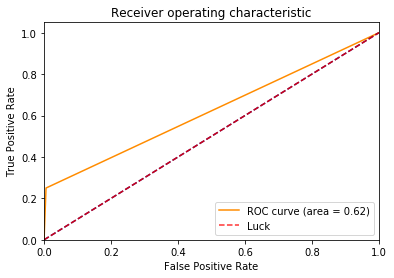

timestamp =  2017-05-28 23:00:04
auc_score =  0.498837209302 	feature importances: [ 0.34  0.46  0.2   0.  ]
timestamp =  2017-05-29 00:00:04
auc_score =  0.608785529716 	feature importances: [ 0.24  0.42  0.34  0.  ]


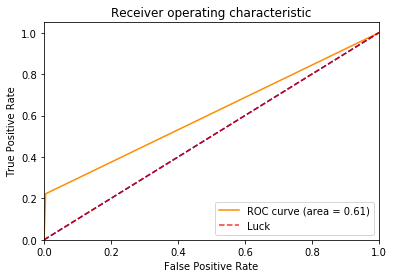

timestamp =  2017-05-29 01:00:04
auc_score =  0.524870801034 	feature importances: [ 0.28  0.42  0.3   0.  ]
timestamp =  2017-05-29 02:00:04
auc_score =  0.512144702842 	feature importances: [ 0.22  0.66  0.12  0.  ]
timestamp =  2017-05-29 03:00:04
auc_score =  0.497674418605 	feature importances: [ 0.5   0.18  0.32  0.  ]
timestamp =  2017-05-29 04:00:04
auc_score =  0.697868217054 	feature importances: [ 0.38  0.28  0.34  0.  ]


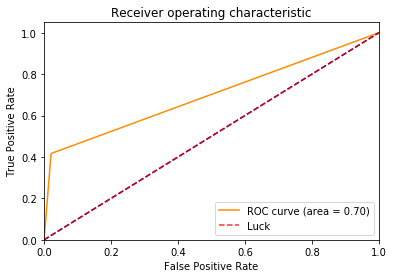

timestamp =  2017-05-29 05:00:04
auc_score =  0.536434108527 	feature importances: [ 0.34  0.24  0.42  0.  ]
timestamp =  2017-05-29 06:00:04
auc_score =  0.497674418605 	feature importances: [ 0.44  0.26  0.3   0.  ]
timestamp =  2017-05-29 07:00:04
auc_score =  0.499418604651 	feature importances: [ 0.26  0.46  0.28  0.  ]
timestamp =  2017-05-29 08:00:04
auc_score =  0.499418604651 	feature importances: [ 0.28  0.44  0.28  0.  ]
timestamp =  2017-05-29 09:00:04
auc_score =  0.759237726098 	feature importances: [ 0.36  0.28  0.36  0.  ]


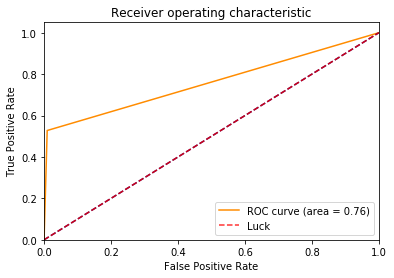

timestamp =  2017-05-29 10:00:04
auc_score =  0.5 	feature importances: [ 0.46  0.22  0.32  0.  ]
timestamp =  2017-05-29 11:00:04
auc_score =  0.644056847545 	feature importances: [ 0.4   0.32  0.28  0.  ]


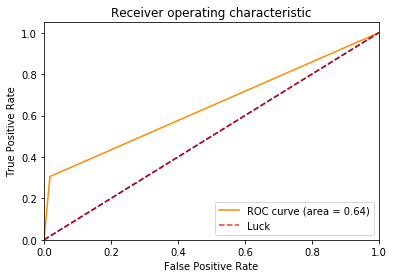

timestamp =  2017-05-29 12:00:04
auc_score =  0.499418604651 	feature importances: [ 0.54  0.28  0.18  0.  ]
timestamp =  2017-05-29 13:00:04
auc_score =  0.499418604651 	feature importances: [ 0.44  0.24  0.32  0.  ]
timestamp =  2017-05-29 14:00:04
auc_score =  0.51330749354 	feature importances: [ 0.4   0.34  0.26  0.  ]
timestamp =  2017-05-29 15:00:04
auc_score =  0.541085271318 	feature importances: [ 0.46  0.34  0.2   0.  ]
timestamp =  2017-05-29 16:00:04
auc_score =  0.537015503876 	feature importances: [ 0.56  0.28  0.16  0.  ]
timestamp =  2017-05-29 17:00:04
auc_score =  0.5 	feature importances: [ 0.38  0.28  0.34  0.  ]
timestamp =  2017-05-29 18:00:04
auc_score =  0.499418604651 	feature importances: [ 0.28  0.42  0.3   0.  ]
timestamp =  2017-05-29 19:00:04
auc_score =  0.512726098191 	feature importances: [ 0.36  0.36  0.28  0.  ]
timestamp =  2017-05-29 20:00:04
auc_score =  0.5 	feature importances: [ 0.48  0.36  0.16  0.  ]
timestamp =  2017-05-29 21:00:04
auc_score

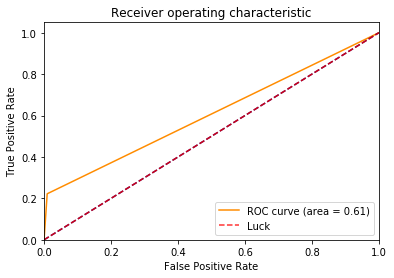

timestamp =  2017-05-30 10:00:04
auc_score =  0.512142672358 	feature importances: [ 0.52  0.28  0.2   0.  ]
timestamp =  2017-05-30 11:00:04
auc_score =  0.578094683741 	feature importances: [ 0.34  0.18  0.48  0.  ]


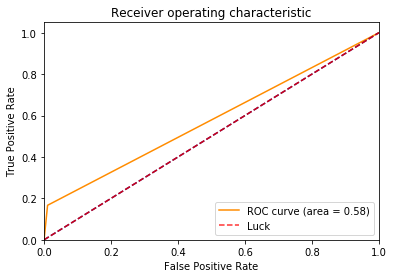

timestamp =  2017-05-30 12:00:04
auc_score =  0.498835855646 	feature importances: [ 0.44  0.32  0.24  0.  ]
timestamp =  2017-05-30 13:00:04
auc_score =  0.527195705601 	feature importances: [ 0.5   0.34  0.16  0.  ]
timestamp =  2017-05-30 14:00:04
auc_score =  0.499417927823 	feature importances: [ 0.32  0.36  0.32  0.  ]
timestamp =  2017-05-30 15:00:04
auc_score =  0.497089639115 	feature importances: [ 0.42  0.26  0.32  0.  ]
timestamp =  2017-05-30 16:00:04
auc_score =  0.578676755918 	feature importances: [ 0.34  0.28  0.36  0.02]


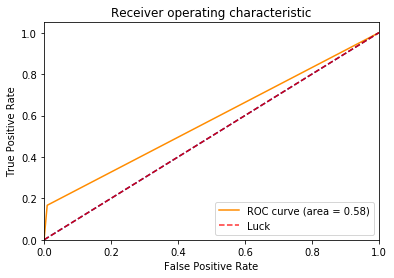

timestamp =  2017-05-30 17:00:04
auc_score =  0.496507566938 	feature importances: [ 0.32  0.26  0.42  0.  ]
timestamp =  2017-05-30 18:00:04
auc_score =  0.498835855646 	feature importances: [ 0.3   0.34  0.36  0.  ]
timestamp =  2017-05-30 19:00:04
auc_score =  0.499417927823 	feature importances: [ 0.36  0.32  0.32  0.  ]
timestamp =  2017-05-30 20:00:04
auc_score =  0.512724744535 	feature importances: [ 0.34  0.38  0.28  0.  ]
timestamp =  2017-05-30 21:00:04
auc_score =  0.498253783469 	feature importances: [ 0.38  0.24  0.38  0.  ]
timestamp =  2017-05-30 22:00:04
auc_score =  0.498253783469 	feature importances: [ 0.34  0.3   0.36  0.  ]
timestamp =  2017-05-30 23:00:04
auc_score =  0.5 	feature importances: [ 0.34  0.5   0.16  0.  ]


In [19]:
#find min and max timestamps

start = Fpl2.index.min()
end = Fpl2.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = Fpl2[(Fpl2.index >= ref_start) & (Fpl2.index < ref_end)]
    #print('ref_df = ', ref_df)
    #print("In while loop: ref_df: ", ref_df)
    sub_df = Fpl2[(Fpl2.index >= ref_end) & (Fpl2.index < ti)]
    #print('sub_df = ', sub_df)
    #print("In while loop: sub_df: ", sub_df)
    
    ref_count = ref_df.shape[0]
    sub_count = sub_df.shape[0] 
    if ref_count < 10 or sub_count < 3:
        auc_score == 0.5
        ti = ti + sub
        count=count+1
        continue
    
    print("timestamp = ", ref_end)
    auc_score = check_for_anomaly(ref_df, sub_df)
    Fpl2.loc[(Fpl2.index>=ref_end) & (Fpl2.index<=ti),['auc_score']] = auc_score
    #print(ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tauc:', auc_score)
    ti = ti + sub
    count=count+1
    


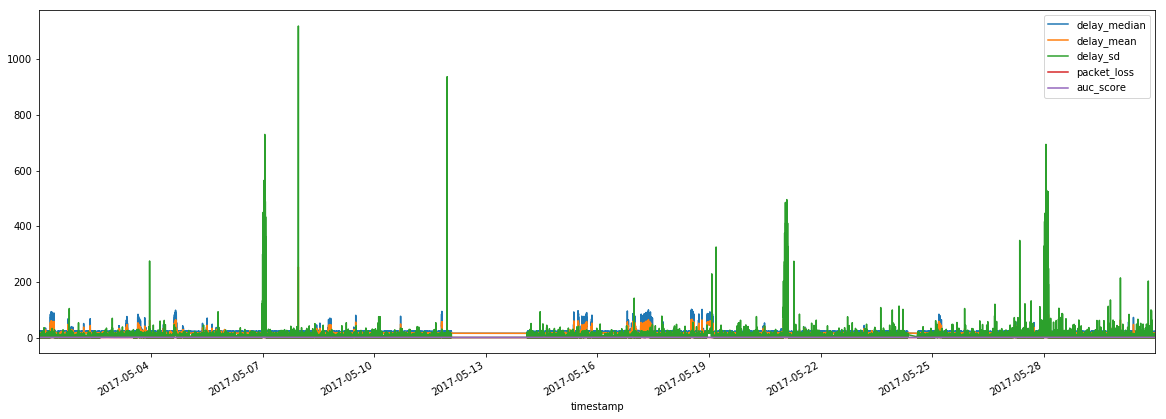

In [20]:
Fpl2.plot(figsize=(20,7))

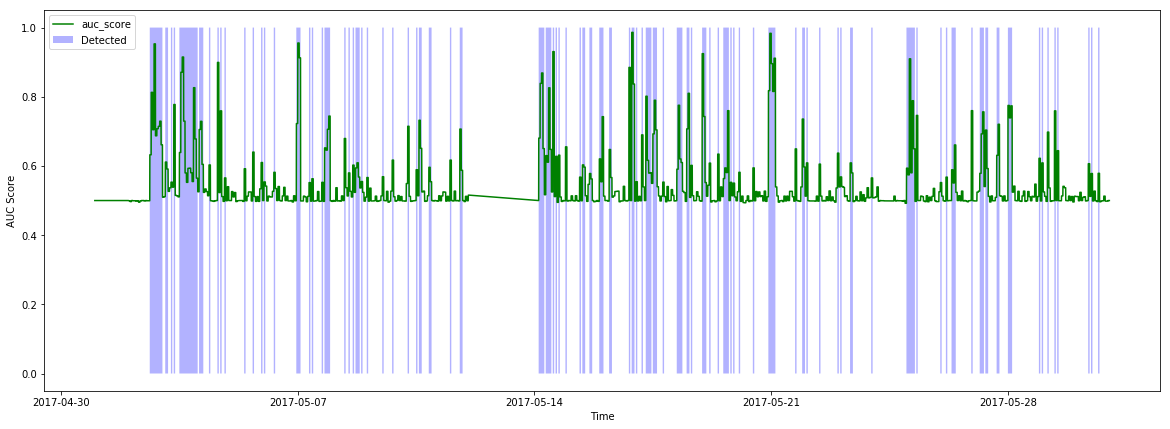

In [21]:
fig, ax = plt.subplots(figsize=(20,7))
Fpl2.loc[:,'Detected'] = 0
Fpl2.loc[Fpl2.auc_score>0.55,'Detected']=1
Fpl2.head()
#ax.plot(Fpl2.Flag, 'r')
ax.plot(Fpl2.auc_score,'g')
ax.fill( Fpl2.Detected, 'b', alpha=0.3)
ax.set_xlabel('Time')
ax.set_ylabel('AUC Score')
ax.legend(loc='upper left')

/usr/lib64/python3.4/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


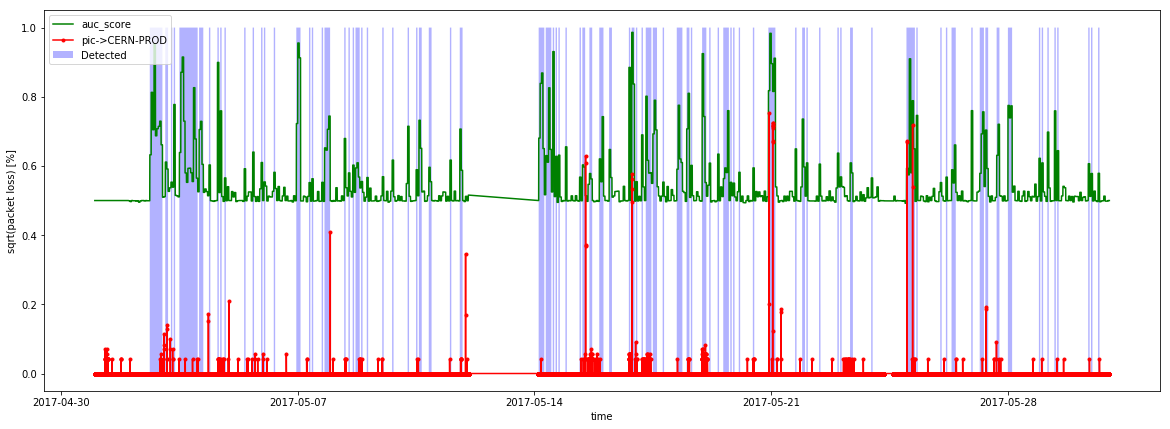

In [22]:
fig, ax = plt.subplots(figsize=(20,7))
Fpl2.loc[:,'Detected'] = 0
Fpl2.loc[Fpl2.auc_score>0.55,'Detected']=1
Fpl2.head()
#ax.plot(Fpl2.Flag, 'r')
ax.plot(Fpl2.auc_score,'g')
ax.fill( Fpl2.Detected, 'b', alpha=0.3)
ax.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', linestyle='-', marker='.', c='r', label=sS+'->'+dS)
ax.set_xlabel('time')
ax.set_ylabel('sqrt(packet loss) [%]')
ax.legend(loc='upper left')
plt.show()

In [23]:
print(Fpl2)

                     delay_median  delay_mean   delay_sd  packet_loss  \
timestamp                                                               
2017-05-01 00:00:04        15.240   15.304733   0.601748          0.0   
2017-05-01 00:00:42        15.210   15.268967   0.394805          0.0   
2017-05-01 00:01:04        15.190   15.243600   0.555692          0.0   
2017-05-01 00:01:42        22.765   15.218700   0.361329          0.0   
2017-05-01 00:02:04        15.180   15.890533   9.572120          0.0   
2017-05-01 00:02:42        15.170   15.190917   0.106413          0.0   
2017-05-01 00:03:04        15.180   15.206683   0.162078          0.0   
2017-05-01 00:03:42        15.200   16.087383  14.567939          0.0   
2017-05-01 00:04:04        15.180   15.202983   0.086500          0.0   
2017-05-01 00:04:42        15.200   15.229767   0.203868          0.0   
2017-05-01 00:05:04        15.200   15.216250   0.146410          0.0   
2017-05-01 00:05:42        15.190   15.243183   0.7

In [24]:
#Fpl2_avg_auc_holder = Fpl2.auc_score
#Fpl2_avg_auc = Fpl2_avg_auc_holder[:'2017-08-15 00:00:00']
#Fpl2_avg_auc.mean()
#ref_start_df = pd.DataFrame(columns=['timestamp'])

#columns1 = ['timestamp', 'auc_score']
#ref_start_df = pd.DataFrame(columns=columns1) 
#ref_start_df.set_index('timestamp')

#print(ref_start_df)




In [25]:
Fpl2_avg_pkt_holder = Fpl2.packet_loss
#holds all the auc scores

timestamp_np = np.array([])
pkt_score_np = np.array([])

start = Fpl2.index.min()
end = Fpl2.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start
count=0
while ti < end + 1 * Minute():
#while start < end:
    ref_start = ti
    ref_end = ti+sub
    
    
    timestamp_np = np.append(timestamp_np, ref_start)
    #create a dataframe that stores the starting time of the each hour
    
    Fpl2_avg_pkt = math.sqrt(Fpl2_avg_pkt_holder[ref_start:ref_end].mean())
    #average packet loss score for every hour    
    
    pkt_score_np = np.append(pkt_score_np, Fpl2_avg_pkt)
    
    #start = start + sub
    
    ti = ti + sub
    #count=count+1
    #if count>2: break

timestamp1_df = pd.DataFrame(timestamp_np[:], columns=['timestamp'])
pkt_score1_df = pd.DataFrame(pkt_score_np[:], columns=['avg_packet_loss'])

pkt_avg_df1 = pd.concat([timestamp1_df, pkt_score1_df], axis=1)

pkt_avg_df2 = pkt_avg_df1.set_index('timestamp')

print(pkt_avg_df2)


                     avg_packet_loss
timestamp                           
2017-05-01 00:00:04         0.000000
2017-05-01 01:00:04         0.000000
2017-05-01 02:00:04         0.000000
2017-05-01 03:00:04         0.000000
2017-05-01 04:00:04         0.000000
2017-05-01 05:00:04         0.000000
2017-05-01 06:00:04         0.000000
2017-05-01 07:00:04         0.014434
2017-05-01 08:00:04         0.012360
2017-05-01 09:00:04         0.009245
2017-05-01 10:00:04         0.000000
2017-05-01 11:00:04         0.000000
2017-05-01 12:00:04         0.004062
2017-05-01 13:00:04         0.000000
2017-05-01 14:00:04         0.000000
2017-05-01 15:00:04         0.000000
2017-05-01 16:00:04         0.000000
2017-05-01 17:00:04         0.000000
2017-05-01 18:00:04         0.006455
2017-05-01 19:00:04         0.000000
2017-05-01 20:00:04         0.000000
2017-05-01 21:00:04         0.000000
2017-05-01 22:00:04         0.000000
2017-05-01 23:00:04         0.000000
2017-05-02 00:00:04         0.003727
2

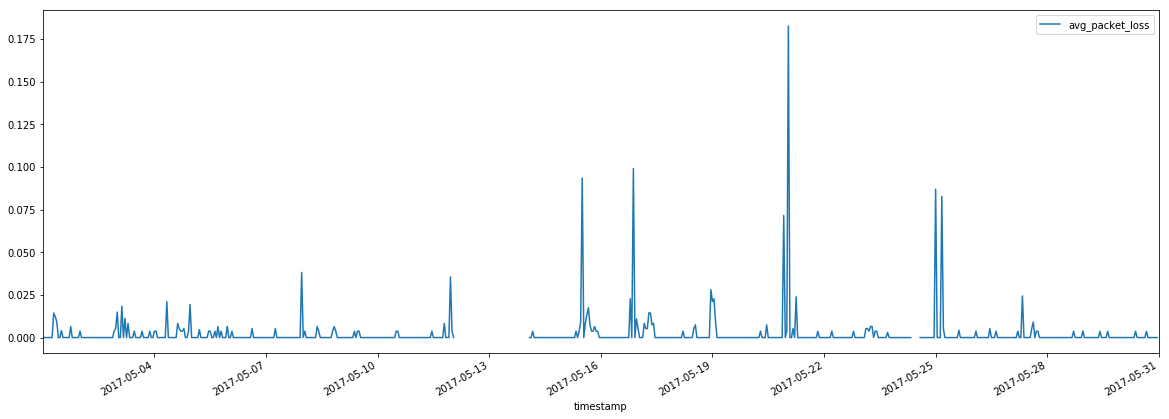

In [26]:
pkt_avg_df2.plot(figsize=(20,7))

In [27]:
# ax = pkt_avg_df2.plot()
# Fpl2.loc[:,'Detected'] = 0
# Fpl2.loc[Fpl2.auc_score>0.51,'Detected']=1
# Fpl2.plot(ax=ax, figsize=(20,7))
# ax.fill( Fpl2.Detected, 'b', alpha=0.3)

/usr/lib64/python3.4/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


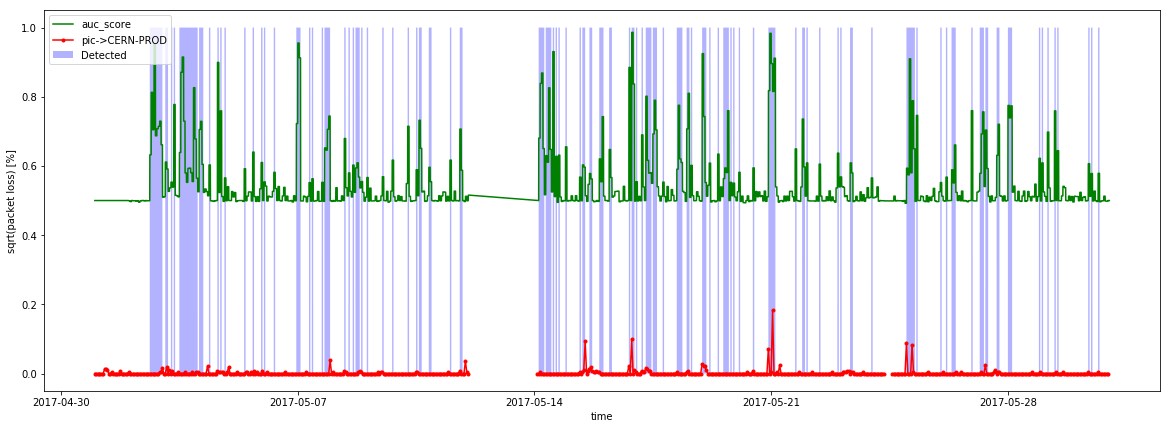

In [28]:
fig, ax = plt.subplots(figsize=(20,7))
Fpl2.loc[:,'Detected'] = 0
Fpl2.loc[Fpl2.auc_score>0.55,'Detected']=1
Fpl2.head()
#ax.plot(Fpl2.Flag, 'r')
ax.plot(Fpl2.auc_score,'g')
ax.fill( Fpl2.Detected, 'b', alpha=0.3)
ax.plot(timestamp1_df, pkt_avg_df2, ls='', linestyle='-', marker='.', c='r', label=sS+'->'+dS)
ax.set_xlabel('time')
ax.set_ylabel('sqrt(packet loss) [%]')
ax.legend(loc='upper left')
plt.show()

/usr/lib64/python3.4/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


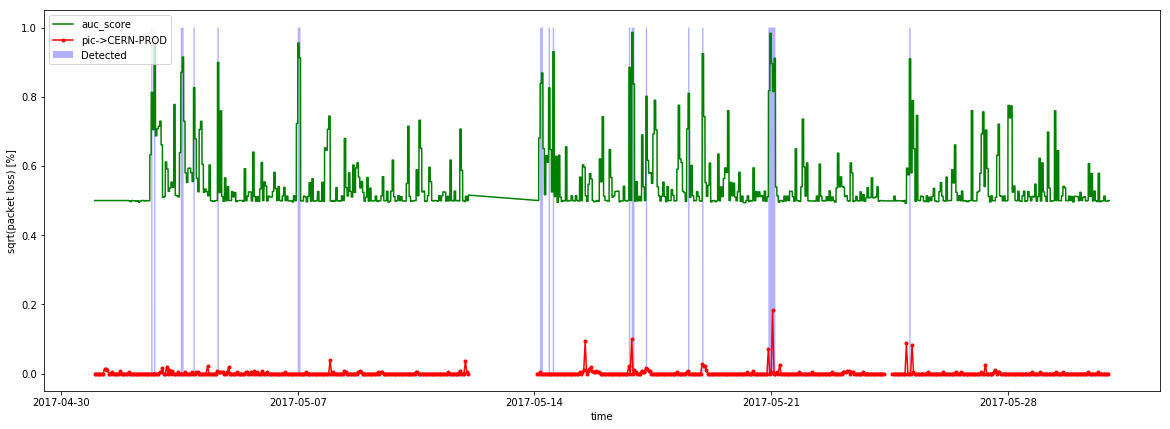

In [29]:
fig, ax = plt.subplots(figsize=(20,7))
Fpl2.loc[:,'Detected'] = 0
Fpl2.loc[Fpl2.auc_score>0.80,'Detected']=1
Fpl2.head()
#ax.plot(Fpl2.Flag, 'r')
ax.plot(Fpl2.auc_score,'g')
ax.fill( Fpl2.Detected, 'b', alpha=0.3)
ax.plot(timestamp1_df, pkt_avg_df2, ls='', linestyle='-', marker='.', c='r', label=sS+'->'+dS)
ax.set_xlabel('time')
ax.set_ylabel('sqrt(packet loss) [%]')
ax.legend(loc='upper left')
plt.show()